In [1]:
import requests
from bs4 import BeautifulSoup
import os
from datetime import datetime
import time
import json
import random
import pandas as pd
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import HTML
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator

api_key = 'pa4DNVDBvsclWxrILVP8FxWFMXlAtAMJ'
params = {'api-key': api_key}
progress_file = 'progress.json'

In [2]:
#PROCESS FOR SEEING IF NYT IS ACCEPTING MY QUERIES
test_url = 'https://api.nytimes.com/svc/archive/v1/2023/1.json'  # A simple test request

def check_rate_limit(api_key):
    params = {'api-key': api_key}
    response = requests.get(test_url, params=params)
    
    print(f"Status Code: {response.status_code}")

    if response.status_code == 200:
        print("Response Headers:")
        for header, value in response.headers.items():
            print(f"{header}: {value}")

        rate_limit = response.headers.get('X-RateLimit-Limit')
        rate_limit_remaining = response.headers.get('X-RateLimit-Remaining')
        rate_limit_reset = response.headers.get('X-RateLimit-Reset')

        print("Rate Limit Status:")
        print(f"Limit: {rate_limit}")
        print(f"Remaining: {rate_limit_remaining}")
        print(f"Reset Time: {rate_limit_reset}")

        if rate_limit_remaining == '0':
            print("You have reached the rate limit. Please wait until the reset time.")
        else:
            print("You can continue making requests.")
    elif response.status_code == 429:
        print("You are currently rate-limited. Please wait before making further requests.")
    else:
        print(f"Request failed with status code: {response.status_code}")

# Check rate limit status
check_rate_limit(api_key)

Status Code: 200
Response Headers:
Date: Mon, 05 Aug 2024 13:44:25 GMT
Content-Type: application/json; charset=UTF-8
Content-Length: 11693417
Connection: keep-alive
Cache-Control: max-age=43200
Expires: Tue, 06 Aug 2024 01:44:25 GMT
Last-Modified: Tue, 31 Jan 2023 21:48:10 GMT
ETag: "ca756d5d8be51c76dd7b5986963a8d42"
x-goog-generation: 1675201690827953
x-goog-metageneration: 2
x-goog-stored-content-encoding: identity
x-goog-stored-content-length: 11693417
x-goog-hash: crc32c=Mm/4vA==, md5=ynVtXYvlHHbde1mGljqNQg==
x-goog-storage-class: MULTI_REGIONAL
Accept-Ranges: bytes
X-GUploader-UploadID: AHxI1nPXuG26kF_wlXJyWyF2iUEYi-i1uOoGWJy5un1Jed82n5tNGWcRMHQn_aXOswY81V1nA00
Server: UploadServer
Alt-Svc: h3=":443"; ma=2592000,h3-29=":443"; ma=2592000
Rate Limit Status:
Limit: None
Remaining: None
Reset Time: None
You can continue making requests.


In [ ]:
#TEST API KEY
test_url = 'https://api.nytimes.com/svc/archive/v1/2022/1.json'
params = {'api-key': api_key}

response = requests.get(test_url, params=params)
print(f"Response Status Code: {response.status_code}")
print(f"Response Headers: {response.headers}")

In [ ]:
#TEST API CALL

# Define the test URL
test_url = 'https://api.nytimes.com/svc/archive/v1/2022/1.json'  # Example for January 2022

# Function to check API key status
def check_api_key(api_key):
    params = {'api-key': api_key}
    response = requests.get(test_url, params=params)
    
    print(f"Request URL: {response.url}")  # Debug print
    print(f"Response Status Code: {response.status_code}")  # Debug print
    
    if response.status_code == 200:
        print("API key is valid. Data fetched successfully.")
        data = response.json()
        print(f"Response Data (first 500 chars): {json.dumps(data)[:500]}")  # Debug print
    else:
        print(f"Failed to fetch data: {response.status_code}")

# Check the API key status
check_api_key(api_key)

In [5]:
# DID THIS ONCE SO NO NEED AGAIN

#FETCH ALL ARTICLES IN 2023

# base_url = 'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json'

# # Define file paths
# articles_file = 'articles_4023.json'

# # Initialize an empty list for articles
# articles_4023 = []

# # Function to fetch articles for a specific month
# def fetch_articles(year, month):
#     url = base_url.format(year=year, month=month)
#     params = {'api-key': api_key}
#     retries = 0
#     max_retries = 5
#     while retries < max_retries:
#         print(f"Fetching URL: {url}")  # Debug print
#         response = requests.get(url, params=params)
#         print(f"Response Status Code: {response.status_code}")  # Debug print
#         if response.status_code == 200:
#             data = response.json()
#             print(f"Response Data (first 500 chars): {json.dumps(data)[:500]}")  # Debug print
#             return data
#         elif response.status_code == 429:
#             retries += 1
#             wait_time = 2 ** retries
#             print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
#             time.sleep(wait_time)
#         else:
#             print(f"Failed to fetch data for {year}-{month}: {response.status_code}")
#             return None
#     print(f"Max retries exceeded for {year}-{month}.")
#     return None

# # Fetch articles for each month in 2023
# for month in range(1, 13):
#     print(f"Starting fetch for 2023-{month:02d}...")  # Debug print
#     data = fetch_articles(2023, month)
    
#     if data:
#         if 'response' in data:
#             if 'docs' in data['response']:
#                 docs = data['response']['docs']
#                 print(f"Found {len(docs)} documents for 2023-{month:02d}.")  # Debug print
#                 if len(docs) == 0:
#                     print(f"No articles found for 2023-{month:02d}.")
                
#                 for article in docs:
#                     articles_4023.append(article)
#                     print(f"Processed article {article.get('web_url', 'URL not available')}")  # Debug print

#             else:
#                 print(f"No 'docs' found in response for 2023-{month:02d}.")
#         else:
#             print(f"No 'response' found in data for 2023-{month:02d}.")
#     else:
#         print(f"No data returned for 2023-{month:02d}.")
#     time.sleep(1)  # To avoid hitting rate limits

# # Save all fetched articles to a file
# with open(articles_file, 'w') as f:
#     json.dump(articles_4023, f)

# print(f"Total articles fetched for 2023: {len(articles_4023)}")

In [ ]:
# NEW CODE TO PULL EARLIER YEARS — FETCHED FOR NOW SO LEAVING OFF

# Base URL for NYTimes Archive API
base_url = 'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json'

# Function to fetch articles for a specific month
def fetch_articles(year, month):
    url = base_url.format(year=year, month=month)
    params = {'api-key': api_key}
    retries = 0
    max_retries = 5
    while retries < max_retries:
        print(f"Fetching URL: {url}")  # Debug print
        response = requests.get(url, params=params)
        print(f"Response Status Code: {response.status_code}")  # Debug print
        if response.status_code == 200:
            data = response.json()
            print(f"Response Data (first 500 chars): {json.dumps(data)[:500]}")  # Debug print
            return data
        elif response.status_code == 429:
            retries += 1
            wait_time = 2 ** retries
            print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Failed to fetch data for {year}-{month}: {response.status_code}")
            return None
    print(f"Max retries exceeded for {year}-{month}.")
    return None

# Fetch articles for the years:
years = [2016]

for year in years:
    articles = []
    for month in range(1, 13):
        print(f"Starting fetch for {year}-{month:02d}...")  # Debug print
        data = fetch_articles(year, month)
        
        if data:
            if 'response' in data:
                if 'docs' in data['response']:
                    docs = data['response']['docs']
                    print(f"Found {len(docs)} documents for {year}-{month:02d}.")  # Debug print
                    if len(docs) == 0:
                        print(f"No articles found for {year}-{month:02d}.")
                    
                    for article in docs:
                        articles.append(article)
                        print(f"Processed article {article.get('web_url', 'URL not available')}")  # Debug print

                else:
                    print(f"No 'docs' found in response for {year}-{month:02d}.")
            else:
                print(f"No 'response' found in data for {year}-{month:02d}.")
        else:
            print(f"No data returned for {year}-{month:02d}.")
        time.sleep(1)  # To avoid hitting rate limits

    # Save all fetched articles to a file
    articles_file = f'articles_{year}.json'
    with open(articles_file, 'w') as f:
        json.dump(articles, f)

    print(f"Total articles fetched for {year}: {len(articles)}")


In [5]:
#COMBINE MY DATA TOGETHER

# Function to load articles from a JSON file into a DataFrame
def load_articles(year):
    articles_file = f'articles_{year}.json'
    with open(articles_file, 'r') as f:
        articles = json.load(f)
    return pd.DataFrame(articles)

# Load articles for each year
df_articles_2014 = load_articles(2014)
df_articles_2015 = load_articles(2015)
df_articles_2016 = load_articles(2016)
df_articles_2017 = load_articles(2017)
df_articles_2018 = load_articles(2018)
df_articles_2019 = load_articles(2019)
df_articles_2020 = load_articles(2020)
df_articles_2021 = load_articles(2021)
df_articles_2022 = load_articles(2022)
df_articles_2023 = load_articles(2023)
df_articles_2024 = load_articles(2024)

# Concatenate all DataFrames into a single DataFrame
df_articles = pd.concat([df_articles_2014, df_articles_2015, df_articles_2016, df_articles_2017, df_articles_2018, df_articles_2019, df_articles_2020, df_articles_2021, df_articles_2022, df_articles_2023, df_articles_2024], ignore_index=True)

# Display general information about the combined DataFrame
print("DataFrame Information:")
print(df_articles.info())

# Display the first few rows of the combined DataFrame
print("\nFirst Few Rows:")
print(df_articles.head())

# Display the columns and their datatypes
print("\nColumns and DataTypes:")
print(df_articles.dtypes)

# Display the number of rows and columns in the combined DataFrame
print("\nDataFrame Shape:")
print(df_articles.shape)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641513 entries, 0 to 641512
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   abstract          641513 non-null  object
 1   web_url           641513 non-null  object
 2   snippet           641513 non-null  object
 3   lead_paragraph    641513 non-null  object
 4   print_section     390814 non-null  object
 5   print_page        390820 non-null  object
 6   source            641513 non-null  object
 7   multimedia        641513 non-null  object
 8   headline          641513 non-null  object
 9   keywords          641513 non-null  object
 10  pub_date          641513 non-null  object
 11  document_type     641513 non-null  object
 12  news_desk         641513 non-null  object
 13  section_name      641513 non-null  object
 14  subsection_name   263627 non-null  object
 15  byline            641513 non-null  object
 16  type_of_materia

In [6]:
#FOR SOME REASON THERE WERE A HANDFUL OF 2007 ARTICLES IN THERE< NEEDED TO DROP

# Convert 'pub_date' to datetime if it isn't already
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')

# Filter out articles published before 2017
articles_before_2014 = df_articles[df_articles['pub_date'].dt.year < 2014]

# Count of articles removed
count_removed = articles_before_2014.shape[0]

# Drop articles published before 2014
df_articles = df_articles[df_articles['pub_date'].dt.year >= 2014]

# Print the count of removed articles
print(f"Count of articles removed: {count_removed}")

# Save the filtered DataFrame as df_articles
df_articles.reset_index(drop=True, inplace=True)  # Optional: Reset the index after dropping rows

Count of articles removed: 10


In [7]:
from IPython.core.display import HTML
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # Adjust column width
pd.set_option('display.width', 1000)  # Set to a large number

# Adjust notebook display width
display(HTML("<style>.container { width:100% !important; }</style>"))

# Display the first 100 rows of the 'byline' column
df_articles['byline'].head(1)

0    {'original': 'By Fred Bierman', 'person': [{'firstname': 'Fred', 'middlename': None, 'lastname': 'Bierman', 'qualifier': None, 'title': None, 'role': 'reported', 'organization': '', 'rank': 1}], 'organization': None}
Name: byline, dtype: object

In [10]:
# #FIRST PROCESS _ OF ARTICLES WITH UNIQUE BYLINE, CHECK FOR LINKED AUTHOR PAGE - BUT CONTINUALLY GETTING BLOCKED

# # Load articles from file
# with open('articles_4023.json', 'r') as f:
#     articles_4023 = json.load(f)

# # Extract unique bylines and their URLs
# unique_bylines = {}
# for article in articles_4023:
#     byline = article['byline']['original'] if article['byline'] else 'No byline'
#     url = article['web_url']
#     if byline not in unique_bylines:
#         unique_bylines[byline] = url

# print(f"Total unique bylines extracted: {len(unique_bylines)}")

# # Save unique bylines to a file (optional, for checkpointing)
# with open('unique_bylines.json', 'w') as f:
#     json.dump(unique_bylines, f)

# # Load progress if exists
# progress_file = 'progress.json'
# if os.path.exists(progress_file):
#     with open(progress_file, 'r') as f:
#         progress = json.load(f)
#     start_idx = progress.get('index', 0)
#     all_byline_links = set(progress.get('byline_links', []))
#     print(f"Resuming from article {start_idx + 1}")
# else:
#     start_idx = 0
#     all_byline_links = set()

# # Function to fetch and parse an article page with exponential backoff
# def fetch_article_page(article_url, retries=5):
#     headers = {
#         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
#     }
#     while retries > 0:
#         try:
#             response = requests.get(article_url, headers=headers)
#             if response.status_code == 200:
#                 return BeautifulSoup(response.text, 'html.parser')
#             elif response.status_code == 403:
#                 print(f"Access forbidden to {article_url}. Retrying after wait...")
#                 time.sleep(random.uniform(60, 120))  # Longer wait before retrying
#                 retries -= 1
#             elif response.status_code == 429:
#                 wait_time = 2 ** (5 - retries)
#                 print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
#                 time.sleep(wait_time)
#                 retries -= 1
#             else:
#                 print(f"Failed to fetch data from {article_url}: {response.status_code}")
#                 return None
#         except requests.RequestException as e:
#             print(f"Request failed: {e}")
#             return None
#     print(f"Max retries exceeded for {article_url}.")
#     return None

# # Function to extract byline links from an article page
# def extract_byline_links(soup):
#     byline_links = []
#     for a_tag in soup.find_all('a', href=True):
#         href = a_tag['href']
#         if href.startswith('https://www.nytimes.com/by/'):
#             byline_links.append(href)
#     return byline_links

# # Fetch and extract byline links for unique articles
# total_bylines = len(unique_bylines)
# for idx, (byline, article_url) in enumerate(list(unique_bylines.items())[start_idx:], start=start_idx + 1):
#     print(f"Processing article {idx}/{total_bylines}: {article_url}")
#     soup = fetch_article_page(article_url)
#     if soup:
#         byline_links = extract_byline_links(soup)
#         all_byline_links.update(byline_links)
#         print(f"Found {len(byline_links)} byline links in article {idx}/{total_bylines}")
#     else:
#         print(f"No content found for article {idx}/{total_bylines}")

#     # Save progress after each article
#     progress = {
#         'index': idx,
#         'byline_links': list(all_byline_links)
#     }
#     with open(progress_file, 'w') as f:
#         json.dump(progress, f)

#     time.sleep(random.uniform(1, 5))  # Randomized wait to avoid detection

# # Print out the unique byline links
# print(f"Total unique byline links found: {len(all_byline_links)}")
# for link in all_byline_links:
#     print(link)

# # Save byline links to a file (optional, for checkpointing)
# with open('byline_links.json', 'w') as f:
#     json.dump(list(all_byline_links), f)

In [11]:
# # MANUALLY REVIEW PROGRESS FILE
# # Load progress file
# progress_file = 'progress.json'

# def review_progress(file_path):
#     try:
#         with open(file_path, 'r') as f:
#             progress = json.load(f)

#         index = progress.get('index', 0)
#         byline_links = progress.get('byline_links', [])

#         # Use a set to find unique byline links
#         unique_byline_links = set(byline_links)

#         print(f"Resumed from article index: {index}")
#         print(f"Total byline links found so far: {len(byline_links)}")
#         print(f"Number of unique byline pages: {len(unique_byline_links)}")

#         # Display some bylines and their URLs
#         if byline_links:
#             print("\nSample byline links:")
#             for link in list(unique_byline_links)[:10]:  # Show first 10 unique links as a sample
#                 print(link)
#         else:
#             print("No byline links found in the progress file.")

#     except FileNotFoundError:
#         print(f"Progress file '{file_path}' not found.")
#     except json.JSONDecodeError:
#         print("Error decoding JSON from the progress file.")
#     except Exception as e:
#         print(f"An error occurred: {e}")

# # Review progress
# review_progress(progress_file)


In [12]:
#ADD NYT2 PROCESS HERE WHICH IS CREATING AND THEN TESTING AUTHOR URLS

In [8]:
#3rd PROCESS, STARTING FROM MAIN DATABASE

# Extract 'byline' field
df_byline = pd.json_normalize(df_articles['byline'])

# Initialize empty lists for authors and their IDs
authors_list = []
author_id_map = {}
author_id_counter = 1

# Iterate over the 'byline' DataFrame to extract authors
for index, row in df_byline.iterrows():
    if 'person' in row and row['person']:
        for person in row['person']:
            # Create a unique key for each author based on their details
            author_key = (person.get('firstname', ''), person.get('middlename', ''), person.get('lastname', ''))
            if author_key not in author_id_map:
                authors_list.append({
                    'author_id': author_id_counter,
                    'firstname': person.get('firstname', ''),
                    'middlename': person.get('middlename', ''),
                    'lastname': person.get('lastname', ''),
                    'qualifier': person.get('qualifier', ''),
                    'title': person.get('title', ''),
                    'role': person.get('role', ''),
                    'organization': person.get('organization', ''),
                    'rank': person.get('rank', '')
                })
                author_id_map[author_key] = author_id_counter
                author_id_counter += 1

# Create DataFrame for authors
df_authors = pd.DataFrame(authors_list)

# Initialize a column for author IDs in the original articles DataFrame
df_articles['author_id'] = None

# Update author IDs in articles DataFrame
for index, row in df_articles.iterrows():
    if 'byline' in row and row['byline']:
        byline = row['byline']
        if 'person' in byline:
            author_id = []
            for person in byline['person']:
                author_key = (person.get('firstname', ''), person.get('middlename', ''), person.get('lastname', ''))
                if author_key in author_id_map:
                    author_id.append(author_id_map[author_key])
            df_articles.at[index, 'author_id'] = author_id

# Save results
df_articles.to_csv('articles_with_authors.csv', index=False)
df_authors.to_csv('authors.csv', index=False)

In [9]:
len(df_authors)

30713

In [10]:
#CREATE fullname and fullname_for_URL


# Function to convert text to Title Case
def to_title_case(name):
    return name.title()

# Function to clean and replace characters
def clean_name(name):
    if pd.isna(name):
        return ''
    name = name.translate(replacement_mapping)  # Replace special characters
    name = name.replace('.', '')  # Remove periods
    name = name.replace("'", '')  # Remove apostrophes
    return name

# Apply Title Case to 'lastname' if in ALL CAPS
df_authors['lastname'] = df_authors['lastname'].apply(
    lambda x: to_title_case(x) if x.isupper() else x
)

# Create 'fullname' column
df_authors['fullname'] = df_authors.apply(
    lambda row: f"{row['firstname']} {row['middlename'] if pd.notna(row['middlename']) else ''} {row['lastname']} {row['qualifier'] if pd.notna(row['qualifier']) else ''}".strip().replace('  ', ' '),
    axis=1
)

# Define replacement mapping for special characters
replacement_mapping = str.maketrans({
    'à': 'a', 'è': 'e', 'ì': 'i', 'ò': 'o', 'ù': 'u',
    'ä': 'a', 'ë': 'e', 'ï': 'i', 'ö': 'o', 'ü': 'u',
    'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
    'ã': 'a', 'ñ': 'n', 'õ': 'o', 'â': 'a', 'ê': 'e',
    'î': 'i', 'ô': 'o', 'û': 'u', 'à': 'a', 'ç': 'c',
    'è': 'e', 'ê': 'e', 'î': 'i', 'ô': 'o', 'ù': 'u'
})

# Create 'fullname_for_url' column
df_authors['fullname_for_url'] = df_authors.apply(
    lambda row: f"{row['firstname']} {row['middlename'] if pd.notna(row['middlename']) else ''} {row['lastname']} {row['qualifier'] if pd.notna(row['qualifier']) else ''}".strip().replace('  ', ' '),
    axis=1
)

# Apply the cleaning function to 'fullname_for_url'
df_authors['fullname_for_url'] = df_authors['fullname_for_url'].apply(clean_name)

# Display the updated DataFrame
print(df_authors.head(10))

   author_id firstname middlename  lastname qualifier title      role organization  rank          fullname  fullname_for_url
0          1      Fred       None   Bierman      None  None  reported                  1      Fred Bierman      Fred Bierman
1          2   Heather       None    Murphy      None  None  reported                  1    Heather Murphy    Heather Murphy
2          3     Annie       None    Lowrey      None  None  reported                  1      Annie Lowrey      Annie Lowrey
3          4    Kareem       None     Fahim      None  None  reported                  1      Kareem Fahim      Kareem Fahim
4          5     Asmaa         Al   Zohairy      None  None  reported                  2  Asmaa Al Zohairy  Asmaa Al Zohairy
5          6     Sandy       None    Keenan      None  None  reported                  1      Sandy Keenan      Sandy Keenan
6          7     Craig       None   Kellogg      None  None  reported                  1     Craig Kellogg     Craig Kellogg


In [11]:
# Create presumed biourl
# Base URL
base_url = 'https://www.nytimes.com/by/'

# Create 'biourl' column
df_authors['biourl'] = df_authors['fullname_for_url'].apply(
    lambda name: base_url + name.replace(' ', '-').lower()
)

print(df_authors[['fullname', 'biourl']].head(10))

           fullname                                       biourl
0      Fred Bierman      https://www.nytimes.com/by/fred-bierman
1    Heather Murphy    https://www.nytimes.com/by/heather-murphy
2      Annie Lowrey      https://www.nytimes.com/by/annie-lowrey
3      Kareem Fahim      https://www.nytimes.com/by/kareem-fahim
4  Asmaa Al Zohairy  https://www.nytimes.com/by/asmaa-al-zohairy
5      Sandy Keenan      https://www.nytimes.com/by/sandy-keenan
6     Craig Kellogg     https://www.nytimes.com/by/craig-kellogg
7      Elaine Louie      https://www.nytimes.com/by/elaine-louie
8    Michael Inouye    https://www.nytimes.com/by/michael-inouye
9      Tim McKeough      https://www.nytimes.com/by/tim-mckeough


In [12]:
#HERE I AM CALCULATING AUHORWORDS PER ARTICLE 

# Calculate the number of authors
df_articles['number_of_authors'] = df_articles['author_id'].str.len()

# Replace 0 with np.nan for division and avoid infinite values
df_articles['number_of_authors'] = df_articles['number_of_authors'].replace(0, np.nan)

# Calculate authorwords and ensure it is an integer
df_articles['authorwords'] = (df_articles['word_count'] / df_articles['number_of_authors']).fillna(0).astype(int)

# Get a summary of the number of articles by number of authors
author_summary = df_articles['number_of_authors'].value_counts().sort_index()

# Print out the summary
for num_authors, count in author_summary.items():
    print(f"{int(num_authors)} author(s) - {count} articles")

1 author(s) - 464523 articles
2 author(s) - 57873 articles
3 author(s) - 11088 articles
4 author(s) - 2595 articles
5 author(s) - 805 articles
6 author(s) - 595 articles
7 author(s) - 695 articles
8 author(s) - 285 articles
9 author(s) - 221 articles
10 author(s) - 228 articles
11 author(s) - 126 articles
12 author(s) - 93 articles
13 author(s) - 40 articles
14 author(s) - 18 articles
15 author(s) - 6 articles
16 author(s) - 2 articles
20 author(s) - 1 articles
29 author(s) - 1 articles


In [13]:
#FINDING MOST PROLIFIC AUTHORS AND PREDOMINATE SECTION

# Step 1: Explode 'author_id' column to individual rows and drop NaN or empty values
df_articles['author_id'] = df_articles['author_id'].apply(lambda x: [str(a) for a in x])
exploded_articles = df_articles.explode('author_id')
exploded_articles = exploded_articles[exploded_articles['author_id'].notna() & exploded_articles['author_id'].astype(bool)]

# Step 2: Convert 'author_id' columns to string for consistency
df_authors['author_id'] = df_authors['author_id'].astype(str)
exploded_articles['author_id'] = exploded_articles['author_id'].astype(str)

# Step 3: Count occurrences of each author_id
author_counts = exploded_articles['author_id'].value_counts().reset_index()
author_counts.columns = ['author_id', 'article_count']

# Step 4: Merge the count of articles into df_authors
df_authors = df_authors.merge(author_counts, how='left', on='author_id')
df_authors['article_count'] = df_authors['article_count'].fillna(0).astype(int)

# Step 5: Count the number of articles each author wrote for each section
section_counts = exploded_articles.groupby(['author_id', 'section_name']).size().reset_index(name='article_count')

# Step 6: Determine the section each author wrote the most for
most_written_section = section_counts.loc[section_counts.groupby('author_id')['article_count'].idxmax()]

# Step 7: Get the second most written section for each author
def get_second_most_written_section(group):
    if len(group) > 1:
        return group.nlargest(2, 'article_count')['section_name'].values[1]
    return None

second_most_written_section = section_counts.groupby('author_id').apply(
    lambda x: pd.Series({'second_most_written_section': get_second_most_written_section(x)})
).reset_index()

# Step 8: Merge the most_written_section with the second_most_written_section
most_written_section = pd.merge(most_written_section, second_most_written_section, on='author_id', how='left')

# Step 9: Merge the section data back into df_authors
df_authors = pd.merge(df_authors, most_written_section[['author_id', 'section_name', 'second_most_written_section']], on='author_id', how='left')
df_authors = df_authors.rename(columns={'section_name': 'most_written_section'})

# Step 10: Drop unnecessary columns if they exist
df_authors = df_authors.drop(columns=['article_count_x', 'article_count_y'], errors='ignore')

# Step 11: Group by author_id and aggregate sums for authorwords and word_count
author_totals = exploded_articles.groupby('author_id').agg({
    'authorwords': 'sum',
    'word_count': 'sum'
}).reset_index()
author_totals = author_totals.rename(columns={'authorwords': 'total_authorwords', 'word_count': 'total_wordcount'})

# Step 12: Merge the totals back into df_authors
df_authors = pd.merge(df_authors, author_totals, on='author_id', how='left')
df_authors['total_authorwords'].fillna(0, inplace=True)
df_authors['total_wordcount'].fillna(0, inplace=True)
df_authors['total_authorwords'] = df_authors['total_authorwords'].astype(int)
df_authors['total_wordcount'] = df_authors['total_wordcount'].astype(int)

# Display the updated DataFrame
print(df_authors.head())

  author_id firstname middlename lastname qualifier title      role organization  rank          fullname  fullname_for_url                                       biourl  article_count most_written_section second_most_written_section  total_authorwords  total_wordcount
0         1      Fred       None  Bierman      None  None  reported                  1      Fred Bierman      Fred Bierman      https://www.nytimes.com/by/fred-bierman             44               Sports                        Arts              35718            35718
1         2   Heather       None   Murphy      None  None  reported                  1    Heather Murphy    Heather Murphy    https://www.nytimes.com/by/heather-murphy            239                 U.S.                     Science             208065           231232
2         3     Annie       None   Lowrey      None  None  reported                  1      Annie Lowrey      Annie Lowrey      https://www.nytimes.com/by/annie-lowrey             65         Busin

/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/1601348942.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  second_most_written_section = section_counts.groupby('author_id').apply(
/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/1601348942.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] 

In [15]:
#SEARCHING FOR STRAGGLER NAMES

# Step 1: Identify authors with a blank last name
blank_lastname_authors = df_authors[df_authors['lastname'].isna() | (df_authors['lastname'].str.strip() == '')]

# Display the results including article_count
blank_lastname_authors = blank_lastname_authors[['author_id', 'firstname', 'lastname', 'article_count']]
print("Authors with blank last names:")
print(blank_lastname_authors)

# Step 2: Get the list of author IDs with blank last names
author_ids_to_remove = blank_lastname_authors['author_id'].tolist()

# Step 3: Find any articles by these authors
# Convert author_id to string in case it is a list in df_articles
def extract_author_ids(author_ids):
    if isinstance(author_ids, list):
        return author_ids
    return [author_ids]

# Apply the function to convert author_ids to lists
df_articles['author_ids'] = df_articles['author_id'].apply(extract_author_ids)

# Filter articles written by these authors
articles_by_blank_lastname_authors = df_articles[df_articles['author_ids'].apply(lambda ids: any(author_id in ids for author_id in author_ids_to_remove))]

# Display articles by these authors
print("Articles by authors with blank last names:")
print(articles_by_blank_lastname_authors[['author_id', 'headline', 'section_name', 'pub_date']].head(10))

# Step 4: Remove these authors from df_authors
df_authors_cleaned = df_authors[~df_authors['author_id'].isin(author_ids_to_remove)]

# Optionally, get the count of removed rows
removed_count = len(df_authors) - len(df_authors_cleaned)
print(f"Number of rows removed: {removed_count}")

# Update df_authors with the cleaned DataFrame
df_authors = df_authors_cleaned


Authors with blank last names:
      author_id                 firstname lastname  article_count
42           43                   Michael                    2979
51           52                     Casey                      15
60           61                                              2627
101         102                        J.                    1139
105         106                       Nbc                      12
186         187                       Eve                     264
237         238                    Daniel                     143
269         270                   Gregory                       4
322         323                    Teller                       2
330         331                     James                     303
406         407                   Charles                     820
414         415                      Lisa                      44
453         454                    Robert                     474
463         464                   Vincent    

     author_id      firstname      lastname  article_count
6615      6616         Maggie      Haberman           3265
41          42            Deb         Amlen           3051
68          69           Paul       Krugman           2985
606        607       Florence     Fabricant           2924
207        208        Michael  de la Merced           2471
3513      3514           Alan     Rappeport           2219
3517      3518        Vanessa      Friedman           2088
344        345           Neil    Genzlinger           2022
1223      1224          David     Leonhardt           1909
277        278            Sam       Roberts           1771
420        421          Peter         Baker           1765
62          63  International       Tribune           1744
1239      1240            Sam        Sifton           1704
434        435          Tyler        Kepner           1675
52          53        Kathryn      Shattuck           1673
114        115           Adam        Liptak           16

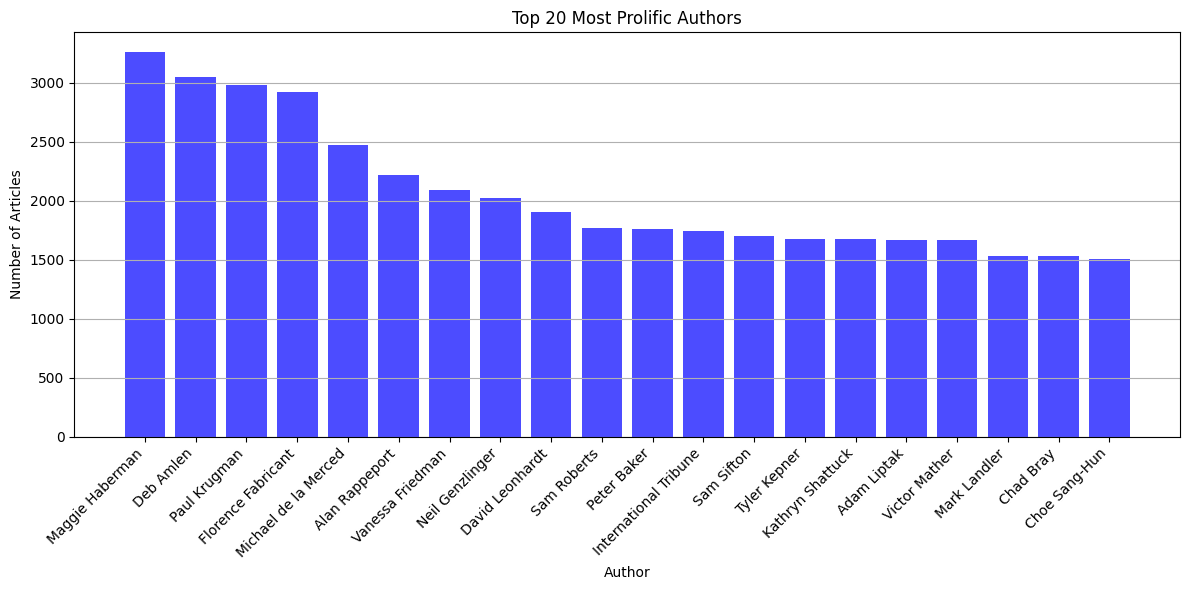

In [16]:
#DISPLAY MOST PROLIFIC AUTHORS

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Optionally, you can set a high width to accommodate wide columns
pd.set_option('display.width', 1000)  # Adjust as needed
pd.set_option('display.max_colwidth', None)  # Show full column width

# Sort the DataFrame by 'article_count' in descending order
df_authors_sorted = df_authors.sort_values(by='article_count', ascending=False)

df_authors_sorted[:20]

# Select the top 20 most prolific authors
top_20_authors = df_authors_sorted.head(20)

# Print the top 20 most prolific authors
print(top_20_authors[['author_id', 'firstname', 'lastname', 'article_count']])

# Plot a histogram of the top 20 most prolific authors
plt.figure(figsize=(12, 6))
plt.bar(top_20_authors['firstname'] + ' ' + top_20_authors['lastname'], top_20_authors['article_count'], color='blue', alpha=0.7)
plt.title('Top 20 Most Prolific Authors')
plt.xlabel('Author')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis='y')

# Adjust layout to ensure labels are not cropped
plt.tight_layout()

# Save the plot as an image file with tight bounding box
plt.savefig('top_20_most_prolific_authors_histogram.png', bbox_inches='tight')

# Display the plot
plt.show()

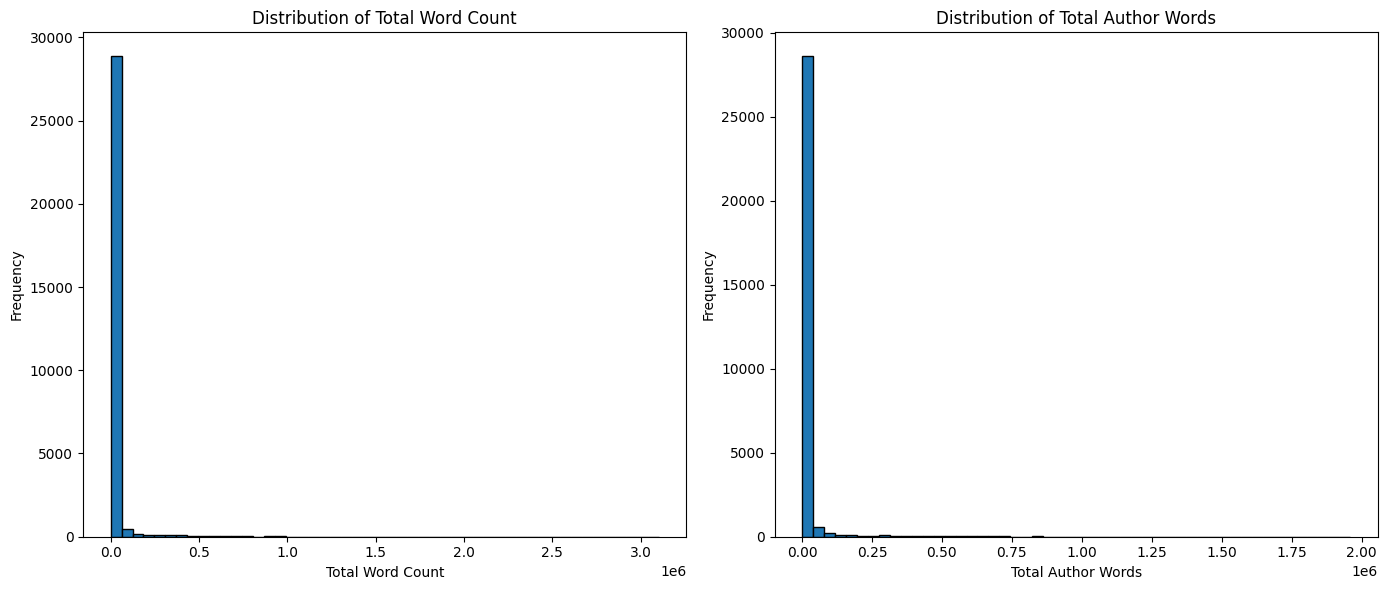

Number of authors with 0 total_wordcount: 3147
Number of authors with 0 total_authorwords: 3150
Number of authors with 0 for both total_wordcount and total_authorwords: 3147


In [17]:
#CHECKING THE WORK
# Ensure 'total_wordcount' and 'total_authorwords' columns exist in df_authors
assert 'total_wordcount' in df_authors.columns, "'total_wordcount' column not found in df_authors"
assert 'total_authorwords' in df_authors.columns, "'total_authorwords' column not found in df_authors"

# Plot histograms using Matplotlib
plt.figure(figsize=(14, 6))

# Histogram for total_wordcount
plt.subplot(1, 2, 1)
plt.hist(df_authors['total_wordcount'].dropna(), bins=50, edgecolor='k')
plt.title('Distribution of Total Word Count')
plt.xlabel('Total Word Count')
plt.ylabel('Frequency')

# Histogram for total_authorwords
plt.subplot(1, 2, 2)
plt.hist(df_authors['total_authorwords'].dropna(), bins=50, edgecolor='k')
plt.title('Distribution of Total Author Words')
plt.xlabel('Total Author Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Count authors with 0 for total_wordcount
zero_wordcount_authors = df_authors[df_authors['total_wordcount'] == 0].shape[0]

# Count authors with 0 for total_authorwords
zero_authorwords_authors = df_authors[df_authors['total_authorwords'] == 0].shape[0]

# Count authors with 0 for both fields
zero_both_authors = df_authors[(df_authors['total_wordcount'] == 0) & (df_authors['total_authorwords'] == 0)].shape[0]

print(f"Number of authors with 0 total_wordcount: {zero_wordcount_authors}")
print(f"Number of authors with 0 total_authorwords: {zero_authorwords_authors}")
print(f"Number of authors with 0 for both total_wordcount and total_authorwords: {zero_both_authors}")

In [18]:
#DISPLAY AUTHORS WITH MOST WORDS

# Sort df_authors by 'total_authorwords' in descending order
top_authors = df_authors.sort_values(by='total_authorwords', ascending=False)

# Select the top 100 authors
top_40_authors = top_authors.head(40)

# Format 'author_words' to be rounded, no decimal, with comma separators
top_40_authors['total_authorwords'] = top_40_authors['total_authorwords'].apply(lambda x: f"{int(x):,}")

# Print just the 'fullname' and 'author_words' columns for the top 100 authors
print(top_40_authors[['fullname', 'total_authorwords']])

# Count the number of authors with zero 'authorwords'
zero_authorwords_count = df_authors[df_authors['total_authorwords'] == 0].shape[0]
print(f"Number of authors with zero 'authorwords': {zero_authorwords_count}")


                      fullname total_authorwords
41                   Deb Amlen         1,959,428
1223           David Leonhardt         1,937,286
434               Tyler Kepner         1,868,658
3517          Vanessa Friedman         1,783,110
68                Paul Krugman         1,726,673
420                Peter Baker         1,686,209
6615           Maggie Haberman         1,644,228
277                Sam Roberts         1,517,502
12223               Rory Smith         1,483,477
121               James Barron         1,424,480
114                Adam Liptak         1,408,021
439               Ross Douthat         1,399,457
344            Neil Genzlinger         1,389,741
268           Richard Sandomir         1,362,766
775         Christopher Clarey         1,347,180
412               Mark Landler         1,299,054
23864            Natasha Frost         1,266,092
457                 Billy Witz         1,257,327
3513            Alan Rappeport         1,240,278
3109       Giovanni 

/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/3699000692.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_40_authors['total_authorwords'] = top_40_authors['total_authorwords'].apply(lambda x: f"{int(x):,}")


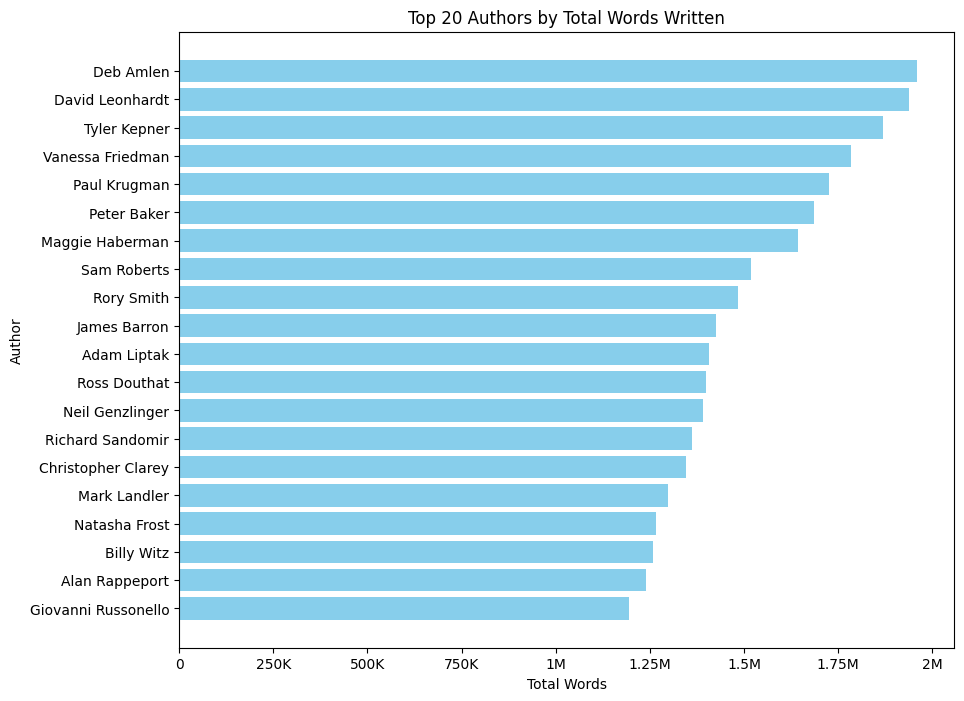

In [19]:
# Define a function to format x-axis values
def format_func(value, tick_number):
    if value >= 1_000_000:
        return f'{int(value / 1_000_000):,}M'
    elif value >= 1_000:
        return f'{int(value / 1_000):,}K'
    else:
        return int(value)

# Sort df_authors by 'total_authorwords' in descending order
top_authors = df_authors.sort_values(by='total_authorwords', ascending=False)

# Select the top 20 authors
top_20_authors = top_authors.head(20)

# Create the histogram
plt.figure(figsize=(10, 8))
plt.barh(top_20_authors['fullname'], top_20_authors['total_authorwords'].astype(int), color='skyblue')
plt.xlabel('Total Words')
plt.ylabel('Author')
plt.title('Top 20 Authors by Total Words Written')
plt.gca().invert_yaxis()  # Invert y-axis to have the top author at the top

# Set the x-axis major formatter to the custom formatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))

# Set the x-axis major locator to include the specific tick intervals
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower'))
plt.xticks(ticks=[0, 250000, 500000, 750000, 1_000_000, 1_250_000, 1_500_000, 1_750_000, 2_000_000],
           labels=['0', '250K', '500K', '750K', '1M', '1.25M', '1.5M', '1.75M', '2M'])

# Save the histogram as a PNG file
plt.savefig('top_20_authors_histogram.png', bbox_inches='tight')

# Display the histogram
plt.show()

In [21]:
#LONGEST ARTICLES
# Flatten the 'headline' column to extract the 'main' headline
df_articles['headline_main'] = df_articles['headline'].apply(lambda x: x.get('main', 'No Title'))

# Filter out articles with 'Ezra Klein' or 'Interviews' in the headline
df_filtered = df_articles[~df_articles['headline_main'].str.contains('Ezra Klein|Interviews|Transcript', case=False, na=False)]

# Sort the filtered DataFrame by 'word_count' in descending order
sorted_articles = df_filtered.sort_values(by='word_count', ascending=False)

# Select the top 20 longest articles
top_40_longest_articles = sorted_articles.head(20)

# Retrieve and format the 'headline_main' and 'word_count' columns
top_40_articles_info = top_40_longest_articles[['headline_main', 'word_count']]

# Print the results in a more readable format
print(top_40_articles_info.to_string(index=False))

                                                                                                            headline_main  word_count
                                                                                                 Inside the Fall of Kabul       20573
                                                                                                              The Fighter       18083
                                                                             Student Winners From Our 2015 Review Contest       17753
On the Shooting in Florida, Student Activism, ‘Black Panther’ and the Olympics: Our Favorite Student Comments of the Week       16338
                                                 The 25 Most Influential Works of American Protest Art Since World War II       15619
                                                                     The Battle for the Mural — and the Future of Belarus       15450
                                                              

In [22]:
# Get the top 10 categories for each column
top_news_desk = df_articles['news_desk'].value_counts().nlargest(12).index
top_section_name = df_articles['section_name'].value_counts().nlargest(12).index

# Filter the DataFrame to include only the top categories
filtered_df = df_articles[df_articles['news_desk'].isin(top_news_desk) & df_articles['section_name'].isin(top_section_name)]

# Create the crosstab
crosstab = pd.crosstab(filtered_df['news_desk'], filtered_df['section_name'], margins=True)

print(crosstab)

section_name   Arts  Books  Business Day  Fashion & Style  Food  Movies  New York  Opinion  Sports  Technology   U.S.  World     All
news_desk                                                                                                                           
                936    321           851              336    58     321       360     3248     126         277   5429   1988   14251
BookReview        5  14446             0                0     0       0         0        0       0           0      0      0   14451
Business        100     29         40792               36    15      16        14        1       9       11214    407    233   52866
Culture       33831   2857           106               11     5    5951        13        0       7           3     68     64   42916
Foreign          56     12           107                6     4       1        20        0      34          10    726  62685   63661
Metro           125      7            27                5    24      

In [91]:
# Find the author with the specified full name
author_info = df_authors[df_authors['fullname'] == 'Andrew Jacobs']

# Check if the author exists and print their primary section
if not author_info.empty:
    primary_section = author_info['most_written_section'].values[0]
    print(f"Primary section of author 'Andrew Jacobs': {primary_section}")
else:
    print("Author 'Andrew Jacobs' not found.")


Primary section of author 'Andrew Jacobs': World


      author_id               fullname  article_count  total_word_count most_written_section second_most_written_section
699         700          Kenneth Chang            867            770848              Science                      Health
189         190            Carl Zimmer            593            628402              Science                      Health
545         546           James Gorman            465            294934              Science                      Health
572         573         Dennis Overbye            371            387605              Science                  Obituaries
7450       7451            Nicholas St            333            204890              Science                      Health
528         529       C. Claiborne Ray            263             60274              Science                      Health
7786       7787           Joanna Klein            253            168139              Science                      Health
645         646       William J.

/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/2200732098.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


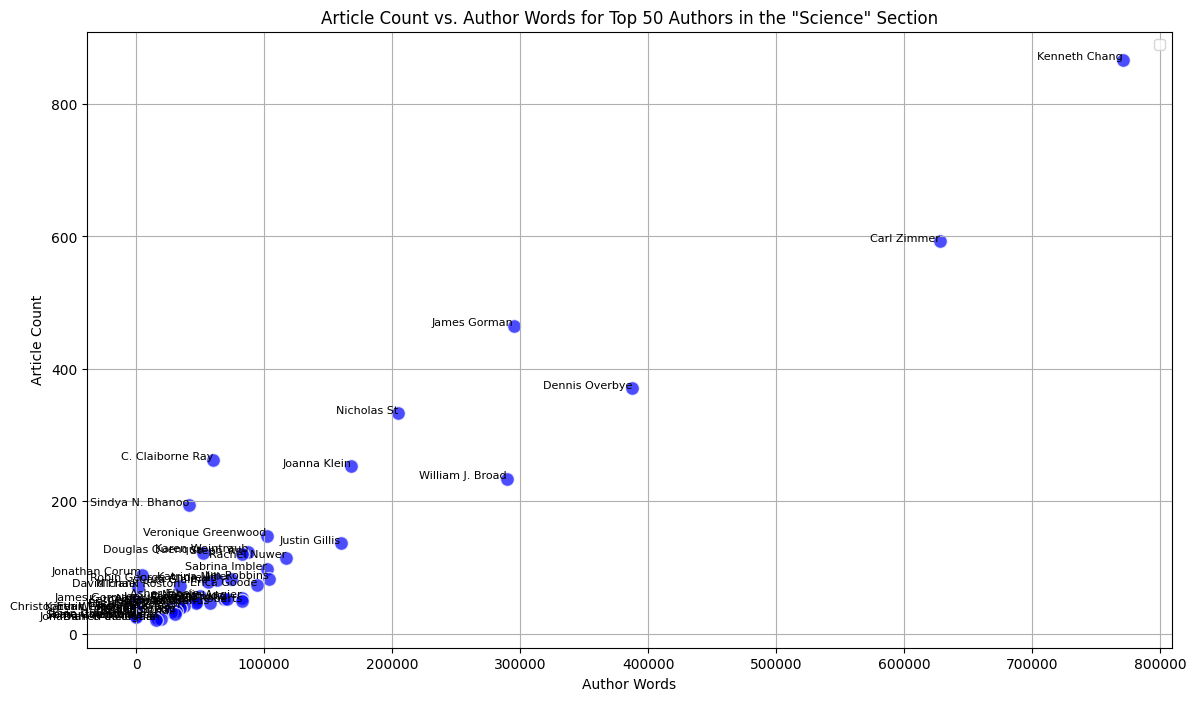

In [90]:
# Define the section name to filter
section_name = 'Science'
highlighted_author_fullname = 'Andrew Jacobs'

# Filter authors writing primarily for the specified section
filtered_authors = df_authors[df_authors['most_written_section'] == section_name]

# Sort the filtered DataFrame by 'article_count' in descending order
filtered_authors_sorted = filtered_authors.sort_values(by='article_count', ascending=False)

# Select the top 50 authors
top_50_authors = filtered_authors_sorted.head(50)

# Print the top 50 authors
print(top_50_authors[['author_id', 'fullname', 'article_count', 'total_word_count', 'most_written_section', 'second_most_written_section']])

# Scatter plot
plt.figure(figsize=(14, 8))

# Plot all authors in blue
plt.scatter(top_50_authors['total_word_count'], top_50_authors['article_count'], alpha=0.7, edgecolors='w', s=100, color='blue')

# Highlight the specified author in red
highlighted_author = top_50_authors[top_50_authors['fullname'] == highlighted_author_fullname]
plt.scatter(highlighted_author['total_word_count'], highlighted_author['article_count'], color='red', s=150, edgecolors='w')

# Labeling the axes
plt.xlabel('Author Words')
plt.ylabel('Article Count')
plt.title(f'Article Count vs. Author Words for Top 50 Authors in the "{section_name}" Section')

# Optional: Annotate points with author names
for i, row in top_50_authors.iterrows():
    plt.annotate(row['fullname'], (row['total_word_count'], row['article_count']), fontsize=8, ha='right')

plt.grid(True)
plt.legend()

# Save the plot as an image file
plt.savefig('top_50_authors_section_highlighted.png')

# Display the plot
plt.show()

In [ ]:
# A WEAK ATTEMPT TO LOOK AT TRENDS ACROSS SECTIONS, BUT I NEED A HYPOTHESIS AND THEN TO PARE DOWN THE DATASET MORE

# Filter authors with 50 or more articles
top_authors = df_authors[df_authors['article_count'] >= 50]

# Sort the filtered DataFrame by 'article_count' in descending order
top_authors_sorted = top_authors.sort_values(by='article_count', ascending=False)

# Print the sorted DataFrame with selected columns
print(top_authors_sorted[['author_id', 'fullname', 'article_count', 'total_authorwords', 'most_written_section']])

# Scatter plot for all top authors, differentiated by section
plt.figure(figsize=(12, 6))

# Define unique colors for different sections
sections = top_authors_sorted['most_written_section'].unique()
colors = plt.get_cmap('tab10', len(sections))  # Use a colormap for distinct colors

# Plot each section with a different color
for idx, section in enumerate(sections):
    section_authors = top_authors_sorted[top_authors_sorted['most_written_section'] == section]
    plt.scatter(section_authors['total_authorwords'], section_authors['article_count'], alpha=0.7, edgecolors='w', s=100, color=colors(idx), label=section)

# Labeling the axes
plt.xlabel('Author Words')
plt.ylabel('Article Count')
plt.title('Article Count vs. Author Words for Authors with 50 or More Articles')

# Optional: Annotate points with author names
for i, row in top_authors_sorted.iterrows():
    plt.annotate(row['fullname'], (row['total_authorwords'], row['article_count']), fontsize=8)

plt.grid(True)
plt.legend()
plt.show()


In [25]:
# MAKING A SUBSET OF AUTHORS WHO ARE WRITING WHAT I CONSIDER THE NEWSPAPER

# Define the excluded sections
excluded_sections = ['Opinion', 'Books', 'Magazine', 'T Magazine', 
                     'Crosswords & Games', 'Reader Center', 'Book Review', 
                     'Multimedia/Photos', 'Corrections', 'Style']

# Filter out authors who write primarily for the excluded sections
df_authors_pros = df_authors[~df_authors['most_written_section'].isin(excluded_sections)]

# If you also want to exclude those who write for the second most written section being in the excluded sections
df_authors_pros = df_authors_pros[~df_authors_pros['second_most_written_section'].isin(excluded_sections)]

# Reset index if needed
df_authors_pros = df_authors_pros.reset_index(drop=True)

len(df_authors_pros)


12086

/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/3158559752.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_20_sections['section_name'], rotation=90)


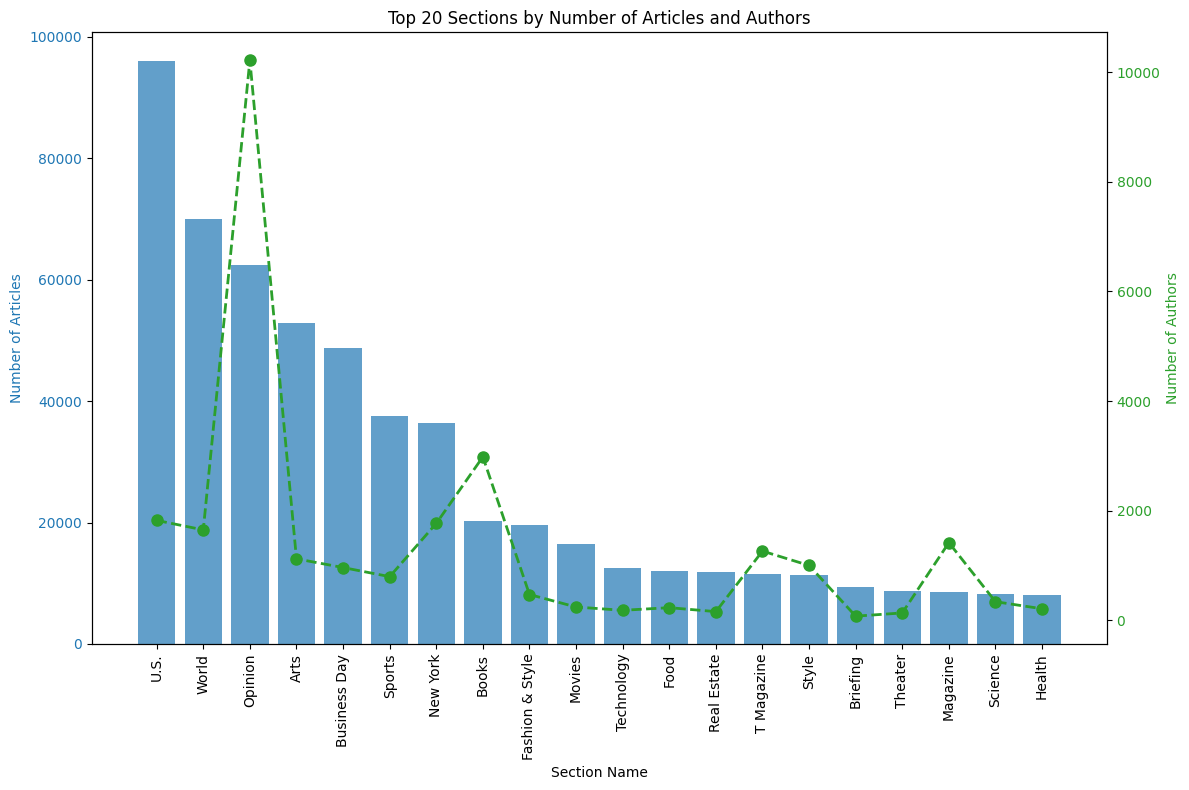

In [26]:
# GENERATE INFORMATION ABOUT EACH SECTION AND WHO WRITES FOR THEM

# Generate the information about each section and who writes for them
article_counts = df_articles['section_name'].value_counts().reset_index()
article_counts.columns = ['section_name', 'num_articles']

authors_counts = df_authors.groupby('most_written_section').size().reset_index(name='num_authors')
authors_counts.columns = ['section_name', 'num_authors']

authors_counts['num_authors'] = authors_counts['num_authors'].astype(int)

authors_with_31_or_more = df_authors_pros[df_authors_pros['article_count'] >= 31]
filtered_authors_counts = authors_with_31_or_more.groupby('most_written_section').size().reset_index(name='num_authors_31_or_more')
filtered_authors_counts.columns = ['section_name', 'num_authors_31_or_more']
filtered_authors_counts['num_authors_31_or_more'] = filtered_authors_counts['num_authors_31_or_more'].astype(int)

df_sections = pd.merge(article_counts, authors_counts, on='section_name', how='outer')
df_sections = pd.merge(df_sections, filtered_authors_counts, on='section_name', how='outer')
df_sections = df_sections.fillna({'num_authors': 0, 'num_authors_31_or_more': 0})
df_sections['num_authors'] = df_sections['num_authors'].astype(int)
df_sections['num_authors_31_or_more'] = df_sections['num_authors_31_or_more'].astype(int)
df_sections = df_sections.sort_values(by='num_articles', ascending=False)

# Select the top 20 sections by number of articles
top_20_sections = df_sections.head(20)

# Plot the histograms
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create a bar plot for number of articles
color = 'tab:blue'
ax1.set_xlabel('Section Name')
ax1.set_ylabel('Number of Articles', color=color)
ax1.bar(top_20_sections['section_name'], top_20_sections['num_articles'], color=color, alpha=0.7, label='Number of Articles')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_20_sections['section_name'], rotation=90)

# Create a second y-axis to plot number of authors
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Number of Authors', color=color)
ax2.plot(top_20_sections['section_name'], top_20_sections['num_authors'], color=color, marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Number of Authors')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustments
plt.title('Top 20 Sections by Number of Articles and Authors')
fig.tight_layout()

# Save the histogram as a PNG file
plt.savefig('top_20_sections_histogram.png')

# Display the histogram
plt.show()

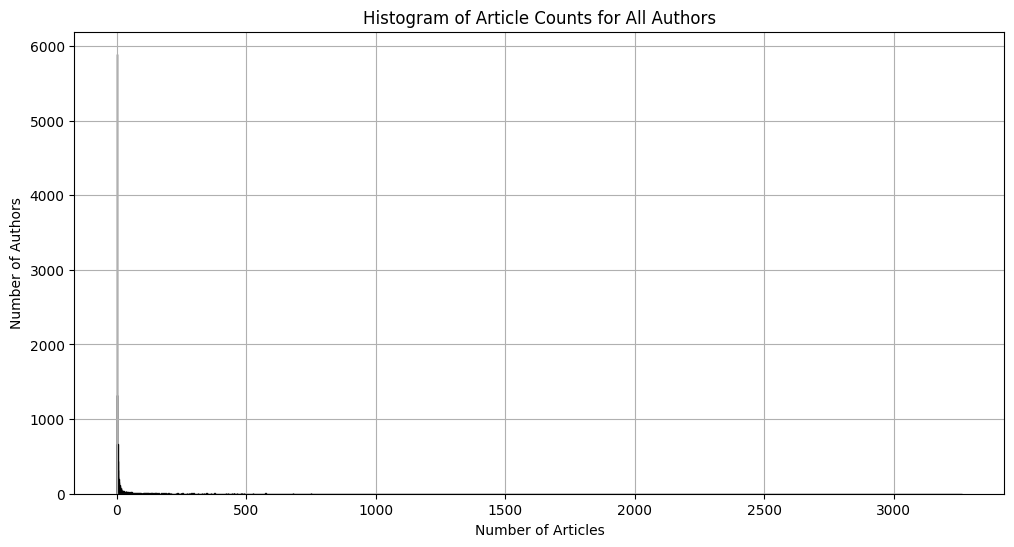

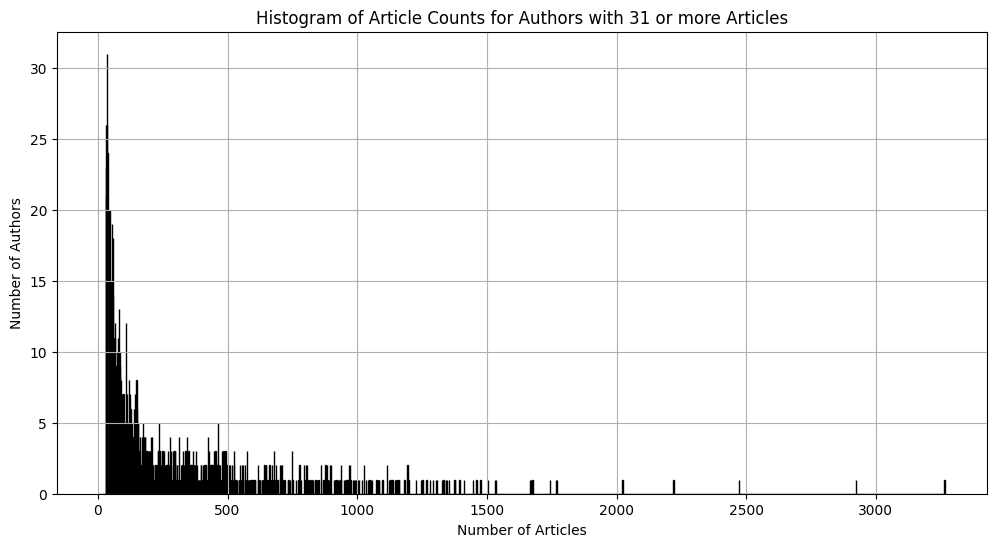

Number of authors with 31 or more articles: 1708


In [27]:
# VISUALIZING THE NEWSPAPER JOURNALISTS

# Create the first histogram for all authors
plt.figure(figsize=(12, 6))
plt.hist(df_authors_pros['article_count'], bins=range(0, df_authors_pros['article_count'].max() + 1), edgecolor='black')
plt.title('Histogram of Article Counts for All Authors')
plt.xlabel('Number of Articles')
plt.ylabel('Number of Authors')
plt.grid(True)
plt.show()

# Filter the DataFrame to include only authors with 31 or more articles
df_authors_pros_filtered = df_authors_pros[df_authors_pros['article_count'] >= 31]

# Create the second histogram for authors with 31 or more articles
plt.figure(figsize=(12, 6))
plt.hist(df_authors_pros_filtered['article_count'], bins=range(5, df_authors_pros_filtered['article_count'].max() + 1), edgecolor='black')
plt.title('Histogram of Article Counts for Authors with 31 or more Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Number of Authors')
plt.grid(True)
plt.show()

# Filter the DataFrame to include only authors with 5 or more articles
authors_with_31_or_more_articles = df_authors_pros[df_authors_pros['article_count'] >= 31]

# Count the number of authors with 31 or more articles
num_authors_with_31_or_more_articles = authors_with_31_or_more_articles.shape[0]

# Print the result
print(f"Number of authors with 31 or more articles: {num_authors_with_31_or_more_articles}")

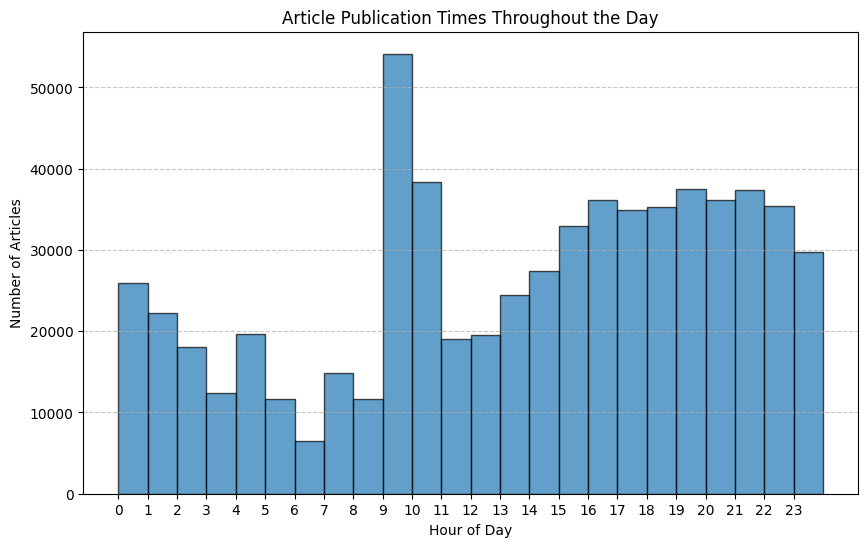

In [28]:
#EXPLORING TIME OF DAY ARTICLES PUBLISH

# Convert 'pub_date' to datetime format
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'])
# Extract the hour from 'pub_date'
df_articles['hour'] = df_articles['pub_date'].dt.hour

# Plot histogram of article publication times throughout the day
plt.figure(figsize=(10, 6))
plt.hist(df_articles['hour'], bins=range(25), edgecolor='black', alpha=0.7)
plt.title('Article Publication Times Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

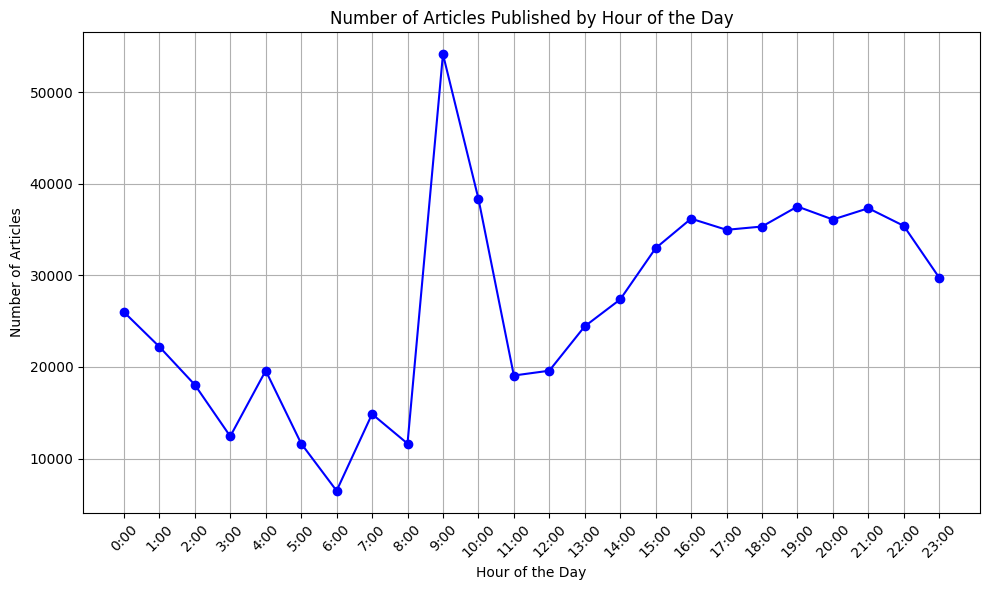

In [29]:
# Extract hour from pub_date
df_articles['hour'] = df_articles['pub_date'].dt.hour
# Count occurrences of each hour
hour_counts = df_articles['hour'].value_counts().sort_index()

# Plot line chart
plt.figure(figsize=(10, 6))
plt.plot(hour_counts.index, hour_counts.values, marker='o', linestyle='-', color='b')
plt.xticks(range(24), [f'{hour}:00' for hour in range(24)], rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.title('Number of Articles Published by Hour of the Day')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Convert 'pub_date' to datetime
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'])

# Extract minute of the day
df_articles['minute_of_day'] = df_articles['pub_date'].dt.hour * 60 + df_articles['pub_date'].dt.minute

# Count the number of articles published at each minute
article_counts = df_articles['minute_of_day'].value_counts().sort_index()

# Define the threshold for peak times
threshold = 3000

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(article_counts.index, article_counts.values, marker='o', linestyle='-')

# Highlight and label the peak times
peak_times = article_counts[article_counts > threshold]
plt.scatter(peak_times.index, peak_times.values, color='red', zorder=5)
for minute in peak_times.index:
    time_label = f'{minute // 60:02}:{minute % 60:02}'
    plt.text(minute, peak_times[minute], time_label, color='red', fontsize=9, ha='center', va='bottom')

# Format the x-axis to show time in HH:MM
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x // 60):02}:{int(x % 60):02}'))

# Set the x-axis and y-axis labels
plt.xlabel('Time of Day')
plt.ylabel('Number of Articles')

# Set x-axis limits to cover the full day from 00:00 to 23:59
plt.xlim(0, 24 * 60)  # 0 to 1440 minutes

# Set y-axis to start from zero
plt.ylim(0, article_counts.max() + 1)

# Set the title
plt.title('Number of Articles Published by Minute of Day')

# Show grid
plt.grid(True)

# Remove extra space at edges and ensure the plot fits into the saved image
plt.tight_layout()

# Save the plot as an image file with tight bounding box
plt.savefig('articles_published_by_minute.png', bbox_inches='tight')

# Display the plot
plt.show()

In [37]:
#DID THIS FOR 2023 ONLY — FOR NOW SKIPPING THE OTHER YEARS

# #CHECKING VALIDITY OF BIOURLS
# # Define file paths
# results_file = 'authors_urls_with_status.csv'
# final_results_file = 'authors_urls_with_status_final.csv'

# # Load existing results
# if os.path.exists(results_file):
#     results_df = pd.read_csv(results_file)
#     processed_urls = results_df[results_df['url_status'].notna()]['biourl'].tolist()
# else:
#     results_df = pd.DataFrame(columns=['author_id', 'biourl', 'url_status'])
#     processed_urls = []

# # Verify the contents of df_authors
# print("First few rows of df_authors:")
# print(df_authors.head())

# # Print debugging info
# print(f"Total rows in df_authors before filtering: {len(df_authors)}")

# # Make a copy of df_authors for processing URLs
# df_authors_copy = df_authors.copy()

# # Normalize URLs in df_authors_copy for consistency
# df_authors_copy['biourl'] = df_authors_copy['biourl'].str.strip().str.lower()

# # Filter out URLs that have already been processed
# df_authors_copy = df_authors_copy[~df_authors_copy['biourl'].isin(processed_urls)]

# # Print debugging info after filtering
# print(f"Total rows in df_authors_copy after filtering: {len(df_authors_copy)}")

# # Add the 'url_status' column to the copy if it doesn't exist
# if 'url_status' not in df_authors_copy.columns:
#     df_authors_copy['url_status'] = None

# # Function to check URL status using GET request
# def check_url_status(url):
#     try:
#         response = requests.head(url, allow_redirects=True)
#         if response.status_code == 200:
#             return 'Valid'
#         elif response.status_code == 403:
#             return 'Forbidden'
#         else:
#             return 'Error: ' + str(response.status_code)
#     except requests.RequestException as e:
#         return f'Error: {e}'

# # Function to process URLs with progress tracking and periodic status report
# def process_urls(df, batch_size=10, delay=1):
#     if df.empty:
#         print("DataFrame is empty. Nothing to process.")
#         return df

#     results = []
#     total = len(df)
#     processed_count = 0
    
#     with tqdm(total=total, desc='Processing URLs') as pbar:
#         for start in range(0, total, batch_size):
#             end = min(start + batch_size, total)
#             batch = df.iloc[start:end]
            
#             print(f"Processing batch {start} to {end}")
            
#             for _, row in batch.iterrows():
#                 url = row['biourl']
#                 status = check_url_status(url)
#                 results.append({'author_id': row['author_id'], 'biourl': url, 'url_status': status})
#                 df.at[row.name, 'url_status'] = status  # Update the DataFrame
#                 pbar.update(1)
#                 processed_count += 1
#                 time.sleep(delay)  # Delay between requests
            
#             if processed_count % 100 == 0:
#                 # Generate and print progress report every 100 URLs
#                 interim_df = pd.DataFrame(results)
#                 generate_progress_report(interim_df)
            
#             # Save progress after each batch
#             df.to_csv(results_file, index=False)
    
#     return df

# # Generate and print progress report
# def generate_progress_report(df):
#     total = len(df)
#     valid = len(df[df['url_status'] == 'Valid'])
#     page_not_found = len(df[df['url_status'] == 'Page Not Found'])
#     forbidden = len(df[df['url_status'] == 'Forbidden'])
#     errors = len(df[df['url_status'].str.startswith('Error')])

#     print(f"\nProgress Report: Total URLs checked: {total}")
#     print(f"Valid: {valid}")
#     print(f"Page Not Found: {page_not_found}")
#     print(f"Forbidden: {forbidden}")
#     print(f"Errors: {errors}\n")

# # Process URLs and save the results
# df_authors_copy = process_urls(df_authors_copy)

# # Save the final results
# df_authors_copy.to_csv(final_results_file, index=False)
# print(f"Final status report saved to '{final_results_file}'.")

# # Generate and print final progress report
# generate_progress_report(df_authors_copy)

In [164]:
# # Drop the specified columns from df_authors
# df_authors = df_authors.drop(columns=['url_status', 'postvalidated_biourl','most_written_section', 'second_most_written_section'],errors='ignore')


In [ ]:
# # REIMPORTING THE URL STATUS AND URLS (including any I fixed manually)
# csv_file_path = 'authors_urls_with_status_final.csv'

# # Rename the 'biourl' column to 'prevalidated_biourl'
# df_authors.rename(columns={'biourl': 'prevalidated_biourl'}, inplace=True)

# # Read the CSV file into a DataFrame
# df_url_status = pd.read_csv(csv_file_path)

# # Ensure 'author_id' is integer in both DataFrames
# df_authors['author_id'] = df_authors['author_id'].astype(int)
# df_url_status['author_id'] = df_url_status['author_id'].astype(int)

# # Merge df_url_status into df_authors on 'author_id'
# df_authors_merged = df_authors.merge(df_url_status[['author_id', 'url_status', 'biourl']], on='author_id', how='left')

# df_authors_merged.head

In [ ]:
# # CHECKING THE MERGE WORKED
# # Assuming df_authors_merged is your DataFrame
# print("Summary of 'biourl' values:")
# print(df_authors_merged['biourl'].value_counts(dropna=False))

# print("\nSummary of 'url_status' values:")
# print(df_authors_merged['url_status'].value_counts(dropna=False))

# print("\nSummary statistics for 'biourl':")
# print(df_authors_merged['biourl'].describe())

# print("\nSummary statistics for 'url_status':")
# print(df_authors_merged['url_status'].describe())


In [167]:
# #MAKING THIS MY MAIN FILE
# df_authors = df_authors_merged

In [168]:
# # Rename the 'biourl' column to 'prevalidated_biourl'
# df_authors.rename(columns={'biourl': 'postvalidated_biourl'}, inplace=True)

In [45]:
#CHECKING I DIDN"T FUCK UP THE AUTHOR ID SOMEHOW

# Filter the DataFrame for the author with fullname "Ted Alcorn"
ted_alcorn = df_authors[df_authors['fullname'] == 'Ted Alcorn']
print("author_id for Ted Alcorn:")
print(ted_alcorn['author_id'].values)

author_id for Ted Alcorn:
['6584']


In [ ]:
# #NOTE THAT FOR SOME REASON I HAVE TO DROP A BUNCH OF AUTHORS WITH BLANK URL_STATUS — THEY WEREN"T PROCESSED FOR SOME REASON SO I DONT HAVE THEIR URLS

# # Step 1: Filter the DataFrame based on url_status, article_count, and exclude NaN url_status
# filtered_authors = df_authors[
#     (df_authors['url_status'].notna()) &  # Exclude rows where url_status is NaN
#     (df_authors['url_status'] != 'Valid') &  # Filter out authors with url_status 'Valid'
#     (df_authors['article_count'] > 2)  # Filter authors with article_count > 2
# ]

# # Step 2: Create a list with the necessary columns and sort by article_count in descending order
# authors_list = filtered_authors[['fullname', 'most_written_section', 'article_count']]
# sorted_authors_list = authors_list.sort_values(by='article_count', ascending=False)

# # Print the sorted list of authors
# print("List of authors in descending order of article_count:")
# print(sorted_authors_list)

# # Step 3: Count the number of authors by section who do not have 'url_status' = 'valid' and have 'article_count' > 2
# section_counts = filtered_authors['most_written_section'].value_counts()

# # Display the counts by section
# print("\nCount of authors by section:")
# print(section_counts)

In [182]:
# #ARE THESE MY COMPETITION?
# # Define the sections of interest
# sections_of_interest = ['Science', 'Health', 'New York']

# # Filter the already filtered DataFrame based on the primary section being in the sections of interest
# filtered_sections = filtered_authors[filtered_authors['most_written_section'].isin(sections_of_interest)]

# # Print the filtered list of authors
# print("List of authors from the filtered group whose primary writing is for Science, Health, or New York:")
# print(filtered_sections[['fullname', 'most_written_section', 'article_count']])


List of authors from the filtered group whose primary writing is for Science, Health, or New York:
                      fullname most_written_section  article_count
710                      Brian             New York              6
949              Benjamin Ryan               Health              5
1097              Ian C. Bates              Science              3
1479       José A. Alvarado Jr             New York              5
1509  Photographs Todd Heisler             New York              3
1566             Amber Bracken               Health              3
1704           Jonah Markowitz             New York              5
2057             Samuel Aranda              Science              3
2724            Britta Lokting             New York              3
3373           Rachel E. Gross              Science              3


/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/272731842.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_page_articles['week'] = pd.to_datetime(front_page_articles['pub_date']).dt.to_period('W').apply(lambda r: r.start_time)
/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/272731842.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_page_articles['month'] = pd.to_datetime(front_page_articles['pub_date']).dt.to_period('M').apply(lambda r: r.start_time)
/va

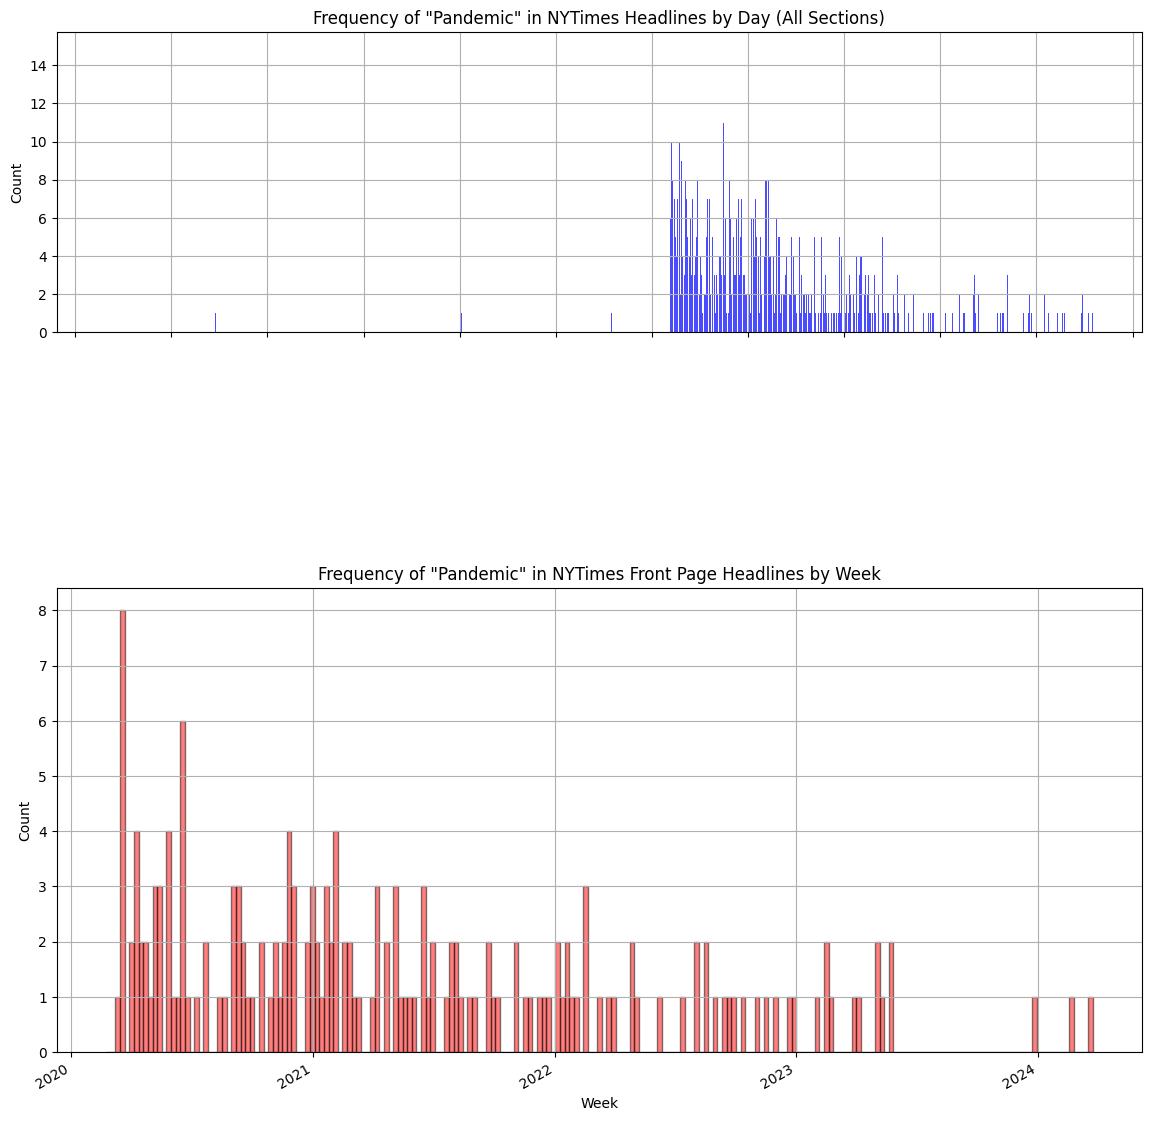

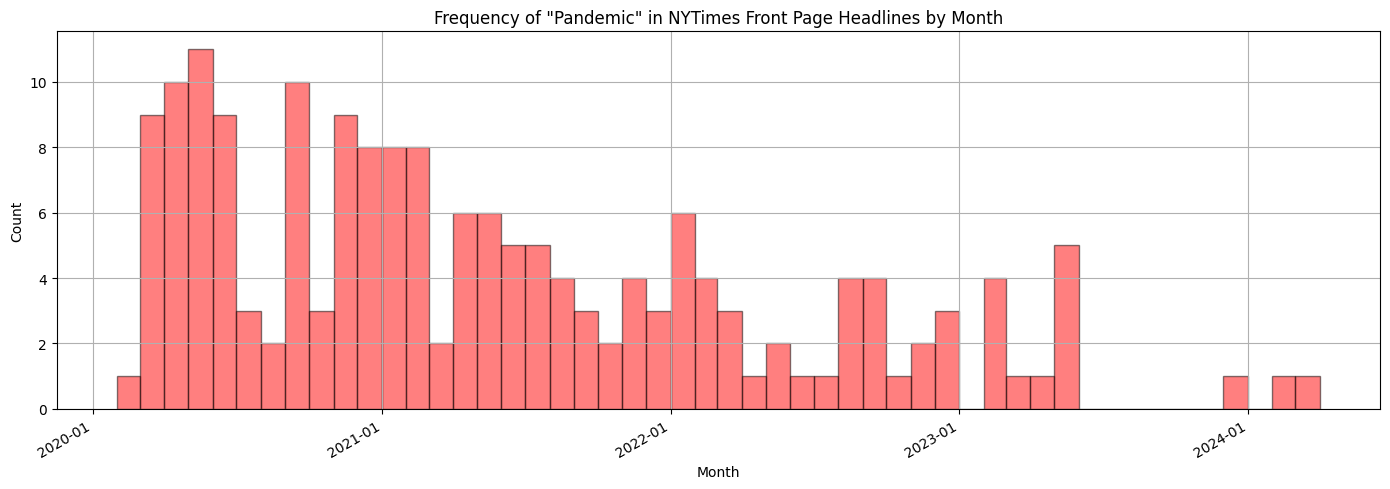

In [51]:
#OK NOW LOOKING FOR FREQUENCY OF A WORD IN THE HEADLINES

# Define the search term
search_term = 'Pandemic'  # Change this to 'Biden' or any other term as needed

# Ensure 'pub_date' is in datetime format
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date']).dt.date

# Filter articles where the search term is in the 'headline_main'
df_articles[search_term.lower() + '_in_headline'] = df_articles['headline_main'].str.contains(search_term, case=False, na=False)

# Filter for front-page articles
front_page_articles = df_articles[(df_articles['print_section'] == 'A') & (df_articles['print_page'] == '1')]

# Count occurrences of the search term in all headlines by day
headlines_by_day = df_articles[df_articles[search_term.lower() + '_in_headline']].groupby('pub_date').size().reset_index(name='count')

# Count occurrences of the search term in front-page headlines by week
front_page_articles['week'] = pd.to_datetime(front_page_articles['pub_date']).dt.to_period('W').apply(lambda r: r.start_time)
front_page_headlines_by_week = front_page_articles[front_page_articles[search_term.lower() + '_in_headline']].groupby('week').size().reset_index(name='count')

# Count occurrences of the search term in front-page headlines by month
front_page_articles['month'] = pd.to_datetime(front_page_articles['pub_date']).dt.to_period('M').apply(lambda r: r.start_time)
front_page_headlines_by_month = front_page_articles[front_page_articles[search_term.lower() + '_in_headline']].groupby('month').size().reset_index(name='count')

# Plot the data
plt.figure(figsize=(14, 15))

# Plot for all headlines by day
plt.subplot(3, 1, 1)
plt.bar(headlines_by_day['pub_date'], headlines_by_day['count'], color='blue', alpha=0.7)
plt.title(f'Frequency of "{search_term}" in NYTimes Headlines by Day (All Sections)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)

# Format x-axis to show only year labels
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Convert 'week' to datetime for plotting
front_page_headlines_by_week['week'] = pd.to_datetime(front_page_headlines_by_week['week'])

# Plot for front-page headlines by week (using histogram)
plt.subplot(2, 1, 2)
plt.hist(front_page_headlines_by_week['week'], 
         bins=pd.date_range(start=front_page_headlines_by_week['week'].min(), 
                            end=front_page_headlines_by_week['week'].max() + pd.DateOffset(weeks=1), 
                            freq='W'), 
         weights=front_page_headlines_by_week['count'], color='red', alpha=0.5, edgecolor='black')

plt.title(f'Frequency of "{search_term}" in NYTimes Front Page Headlines by Week')
plt.xlabel('Week')
plt.ylabel('Count')
plt.grid(True)

# Format x-axis to show only year labels
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.tight_layout()
plt.show()

# Convert 'month' to datetime for plotting
front_page_headlines_by_month['month'] = pd.to_datetime(front_page_headlines_by_month['month'])

# Plot for front-page headlines by month (using histogram)
plt.figure(figsize=(14, 5))
plt.hist(front_page_headlines_by_month['month'], 
         bins=pd.date_range(start=front_page_headlines_by_month['month'].min(), 
                            end=front_page_headlines_by_month['month'].max() + pd.DateOffset(months=1), 
                            freq='MS'), 
         weights=front_page_headlines_by_month['count'], color='red', alpha=0.5, edgecolor='black')

plt.title(f'Frequency of "{search_term}" in NYTimes Front Page Headlines by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(True)

# Format x-axis to show only year and month labels
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.tight_layout()
plt.show()

/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/3926935706.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_page_articles['month'] = pd.to_datetime(front_page_articles['pub_date']).dt.to_period('M').apply(lambda r: r.start_time)


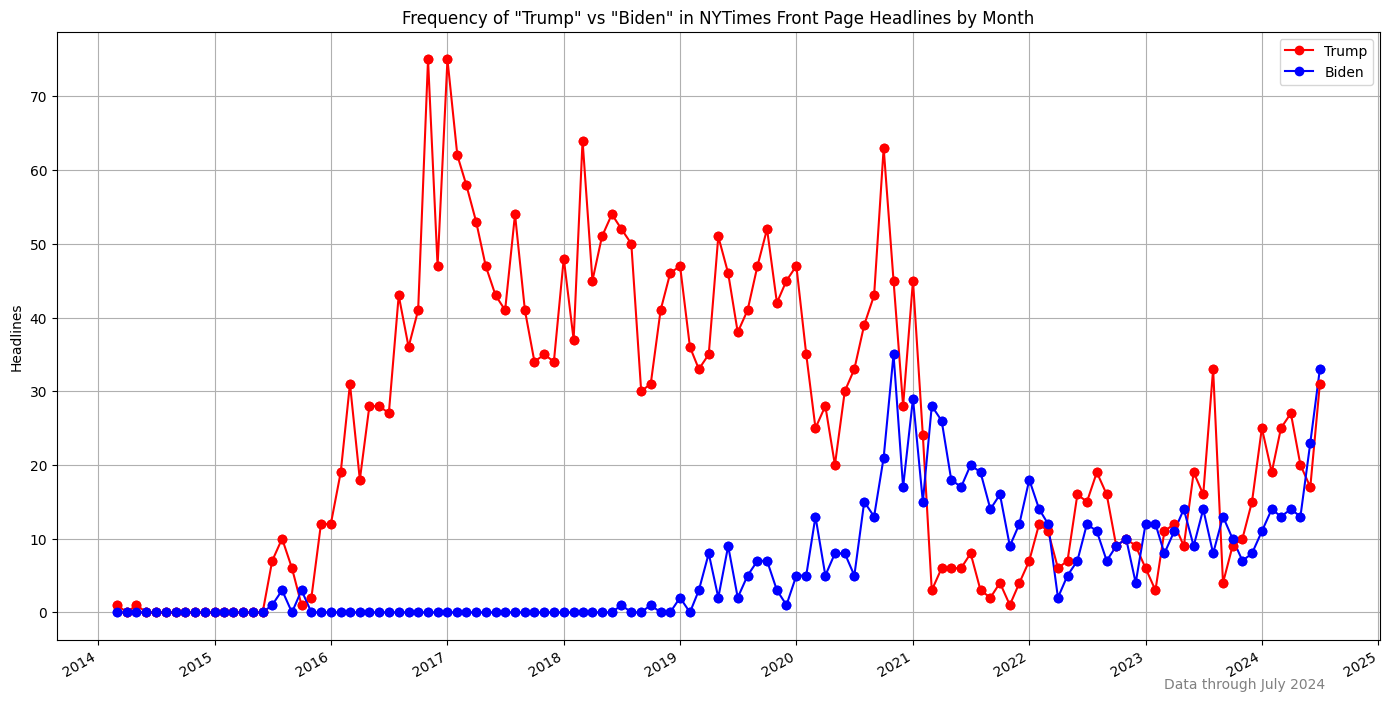

In [34]:
# Define the terms you want to compare
term1 = 'Trump'
term2 = 'Biden'

# Ensure 'pub_date' is in datetime format
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date']).dt.date

# Filter articles for each term
df_articles[term1 + '_in_headline'] = df_articles['headline_main'].str.contains(term1, case=False, na=False)
df_articles[term2 + '_in_headline'] = df_articles['headline_main'].str.contains(term2, case=False, na=False)

# Filter for front-page articles
front_page_articles = df_articles[(df_articles['print_section'] == 'A') & (df_articles['print_page'] == '1')]

# Count occurrences of each term in front-page headlines by month
front_page_articles['month'] = pd.to_datetime(front_page_articles['pub_date']).dt.to_period('M').apply(lambda r: r.start_time)

term1_monthly_counts = front_page_articles[front_page_articles[term1 + '_in_headline']].groupby('month').size().reset_index(name='count')
term2_monthly_counts = front_page_articles[front_page_articles[term2 + '_in_headline']].groupby('month').size().reset_index(name='count')

# Set the end date to July 2024
end_date = pd.Timestamp('2024-07-01')

# Create a complete date range for plotting
all_months = pd.date_range(start=term1_monthly_counts['month'].min(), end=end_date, freq='MS')

# Reindex data to ensure all months are included
term1_monthly_counts = term1_monthly_counts.set_index('month').reindex(all_months, fill_value=0).reset_index()
term1_monthly_counts.rename(columns={'index': 'month'}, inplace=True)

term2_monthly_counts = term2_monthly_counts.set_index('month').reindex(all_months, fill_value=0).reset_index()
term2_monthly_counts.rename(columns={'index': 'month'}, inplace=True)

# Plot the data
plt.figure(figsize=(14, 7))

# Plot for term1
plt.plot(term1_monthly_counts['month'], term1_monthly_counts['count'], color='red', marker='o', label=term1)

# Plot for term2
plt.plot(term2_monthly_counts['month'], term2_monthly_counts['count'], color='blue', marker='o', label=term2)

# Add dots where there are data points
plt.scatter(term1_monthly_counts['month'], term1_monthly_counts['count'], color='red', marker='o', zorder=5)
plt.scatter(term2_monthly_counts['month'], term2_monthly_counts['count'], color='blue', marker='o', zorder=5)

plt.title(f'Frequency of "{term1}" vs "{term2}" in NYTimes Front Page Headlines by Month')
plt.ylabel('Headlines')
plt.legend()
plt.grid(True)

# Format x-axis to show year labels
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Add note on the bottom right
note_text = "Data through July 2024"
plt.figtext(0.95, 0.015, note_text, ha='right', va='center', fontsize=10, color='grey')

# Save the plot as a JPG file
plt.savefig('headlines_comparison.jpg', format='jpg', dpi=300)

plt.tight_layout()
plt.show()



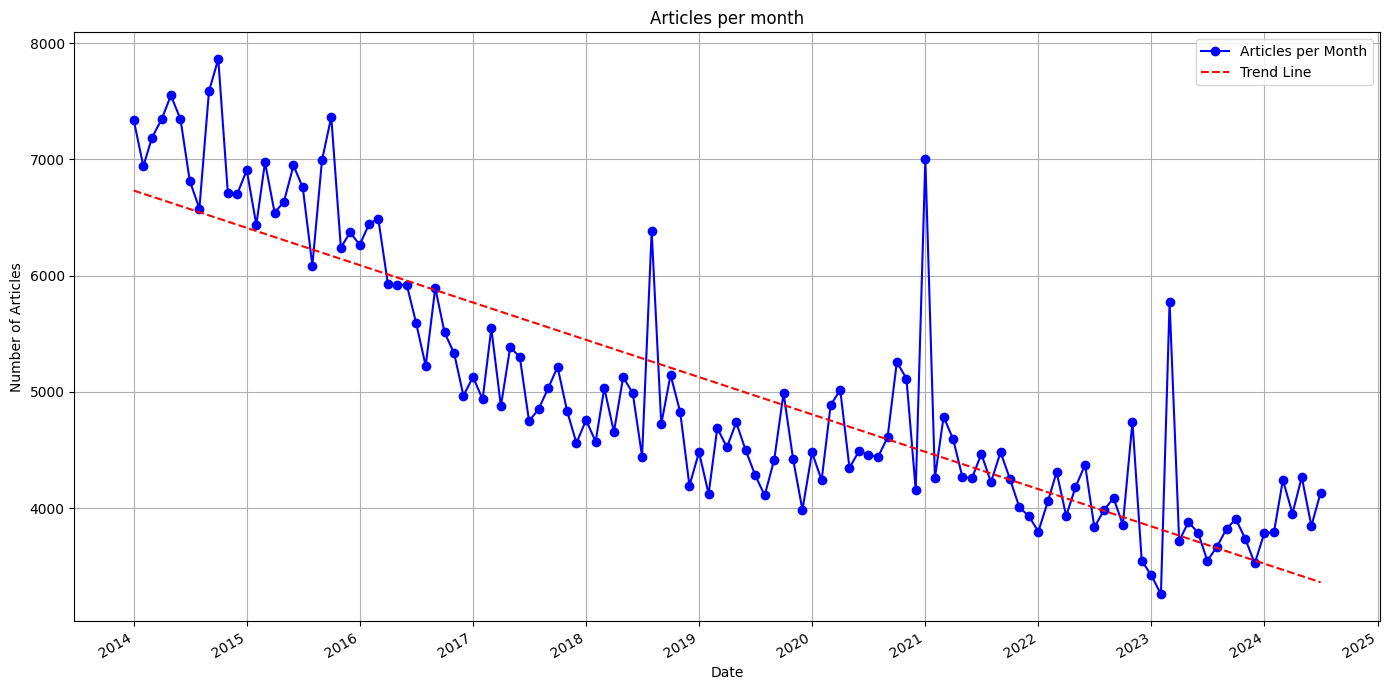

In [77]:
# Ensure 'pub_date' is in datetime format
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'])

# Extract year and month from the 'pub_date'
df_articles['year_month'] = df_articles['pub_date'].dt.to_period('M').dt.to_timestamp()

# Determine the last complete month (excluding August 2024)
last_complete_month = pd.Timestamp('2024-07-31')

# Filter the DataFrame to include only up to the last complete month
df_filtered = df_articles[df_articles['year_month'] <= last_complete_month]

# Count the number of articles per month
articles_per_month = df_filtered.groupby('year_month').size().reset_index(name='count')

# Plot the data
plt.figure(figsize=(14, 7))

# Plot the number of articles per month
plt.plot(articles_per_month['year_month'], articles_per_month['count'], marker='o', linestyle='-', color='blue', label='Articles per Month')

# Add a trend line
z = np.polyfit(mdates.date2num(articles_per_month['year_month']), articles_per_month['count'], 1)
p = np.poly1d(z)
plt.plot(articles_per_month['year_month'], p(mdates.date2num(articles_per_month['year_month'])), linestyle='--', color='red', label='Trend Line')

# Format x-axis to show only year labels
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Articles per month')
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot as an image file
plt.savefig('articles_per_month_trend.png')

# Display the plot
plt.show()

Mean number of articles per day: 165.85
Outliers (articles per day):
pub_date
2014-04-07     433
2018-08-28    2010
2020-11-03     901
2021-01-05     851
2021-01-27    2010
2022-11-08    1021
2023-03-28    2010
Name: count, dtype: int64


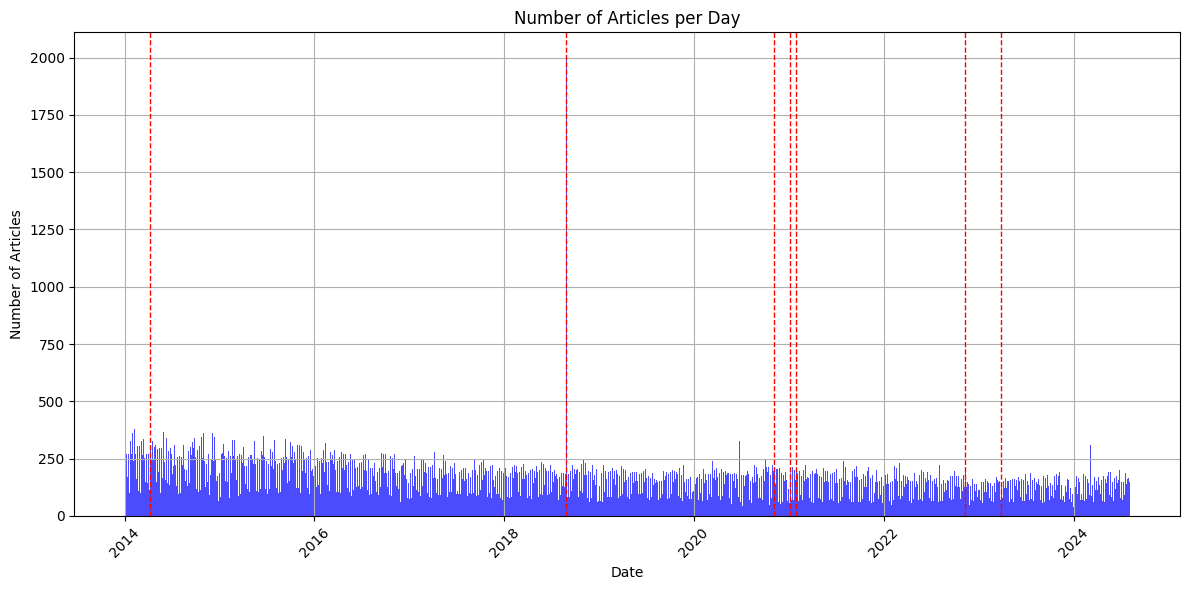

In [35]:
#SUDDENLY REALIZED I NEEDED TO CHECK DATA INTEGRITY — LOOKING AT ARICLES PER DAY

# Ensure 'pub_date' is in datetime format
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date']).dt.date

# Count the number of articles per day
articles_by_day = df_articles['pub_date'].value_counts().sort_index()

# Calculate statistics
mean_count = articles_by_day.mean()
std_count = articles_by_day.std()

# Define outlier thresholds
upper_threshold = mean_count + 3 * std_count
lower_threshold = mean_count - 3 * std_count

# Identify outliers
outliers = articles_by_day[(articles_by_day > upper_threshold) | (articles_by_day < lower_threshold)]

# Print outliers with mean count
print(f"Mean number of articles per day: {mean_count:.2f}")
print("Outliers (articles per day):")
print(outliers)

# Plot histogram of articles by day
plt.figure(figsize=(12, 6))
plt.hist(articles_by_day.index, bins=len(articles_by_day), weights=articles_by_day.values, color='blue', alpha=0.7)
plt.title('Number of Articles per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)

# Highlight outliers on the plot
for date in outliers.index:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1)

# Save the plot as an image file
plt.savefig('articles_per_day_histogram.png')

plt.tight_layout()
plt.show()

In [36]:
# Get the count of articles grouped by section for each outlier day
for outlier_date in outliers.index:
    print(f"\nArticles on {outlier_date} grouped by section (sorted in descending order):")
    section_counts = df_articles[df_articles['pub_date'] == outlier_date].groupby('section_name').size().sort_values(ascending=False)
    print(section_counts)


Articles on 2014-04-07 grouped by section (sorted in descending order):
section_name
Health                163
Business Day           57
World                  34
Arts                   32
Opinion                25
Sports                 22
New York               18
Science                16
U.S.                   15
Education               9
T Magazine              8
Multimedia/Photos       6
Technology              6
Food                    5
Blogs                   4
Fashion & Style         3
Travel                  2
Books                   2
Automobiles             2
Corrections             1
Theater                 1
Crosswords & Games      1
Obituaries              1
dtype: int64

Articles on 2018-08-28 grouped by section (sorted in descending order):
section_name
Opinion                 1016
Multimedia/Photos        717
Arts                      38
Business Day              38
World                     34
Sports                    34
Washington                26
U.S.          

In [37]:
# List of outlier days
outlier_days = ['2014-04-07','2021-01-05', '2021-01-27', '2022-11-08', '2023-03-28','2018-08-28','2020-11-03']

# Prepare a dictionary to store the results
results = {}

# Convert pub_date to datetime if it's not already
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date']).dt.date

# Filter articles for the outlier days
filtered_articles = df_articles[df_articles['pub_date'].isin(pd.to_datetime(outlier_days).date)]

# Loop through each outlier date
for date in outlier_days:
    # Filter articles for the specific outlier date
    daily_articles = filtered_articles[filtered_articles['pub_date'] == pd.to_datetime(date).date()]
    
    # Group by section_name and sort in descending order of number of articles
    section_counts = daily_articles['section_name'].value_counts()
    
    # Find sections with a large number of articles (e.g., more than 50)
    large_sections = section_counts[section_counts > 50].index  # Adjust threshold as needed
    
    for section in large_sections:
        # Filter articles for the specific section
        section_articles = daily_articles[daily_articles['section_name'] == section]
        
        # Get the first 100 headlines
        top_headlines = section_articles.head(100)[['headline_main', 'section_name', 'pub_date']]
        
        # Store the results
        results[f'{date} - {section}'] = top_headlines

# Print out results
for key, df in results.items():
    print(f"\nTop 100 headlines for section '{key}':")
    print(df.to_string(index=False))


Top 100 headlines for section '2014-04-07 - Health':
                                      headline_main section_name   pub_date
                   Life With a Dog: You Meet People       Health 2014-04-07
Circumcision Benefits Outweigh Risks, Study Reports       Health 2014-04-07
                               Bone Fracture Repair       Health 2014-04-07
                     Bone fracture repair  - series       Health 2014-04-07
                     Bone fracture repair  - series       Health 2014-04-07
                     Bone fracture repair  - series       Health 2014-04-07
                                          Breathing       Health 2014-04-07
                              CPR - infant - series       Health 2014-04-07
                                  Joint Dislocation       Health 2014-04-07
                          Creating a sling - series       Health 2014-04-07
                                         Concussion       Health 2014-04-07
                 Patient Voices: S

In [38]:
#LOOKING AT FRIENDS

df_ted = df_authors[df_authors['fullname'] == "Ted Alcorn"]
df_andrew = df_authors[df_authors['fullname'] == "Andrew Jacobs"]
df_dan = df_authors[df_authors['fullname'] == "Dan Levin"]

In [39]:
df_ted['article_count']

16463    31
Name: article_count, dtype: int64

In [40]:
#LOOKING INTO WORDINESS

# Create a set of author IDs for faster lookups
author_ids = set(df_authors['author_id'])

# Pre-filter articles to only include those with relevant author IDs
df_articles_filtered = df_articles[df_articles['author_id'].apply(lambda x: any(author_id in author_ids for author_id in x))]

# Explode the articles DataFrame so each author_id has its own row
df_articles_exploded = df_articles_filtered.explode('author_id')

# Calculate total_word_count for each author_id
total_word_count_series = df_articles_exploded.groupby('author_id')['word_count'].sum()

# Map the total_word_count back to the authors DataFrame
df_authors['total_word_count'] = df_authors['author_id'].map(total_word_count_series).fillna(0).astype(int)

# Step 2: Filter authors with 31 or more articles
filtered_authors = df_authors[df_authors['article_count'] >= 31].copy()

# Step 3: Calculate words per article for each author
filtered_authors['words_per_article'] = (filtered_authors['total_word_count'] / filtered_authors['article_count']).astype(int)

# Step 4: Find the author with the most and least words per article for each most_written_section
most_wordy_authors = filtered_authors.loc[filtered_authors.groupby('most_written_section')['words_per_article'].idxmax()]
least_wordy_authors = filtered_authors.loc[filtered_authors.groupby('most_written_section')['words_per_article'].idxmin()]

# Merge the results to display side by side
result = pd.merge(most_wordy_authors, least_wordy_authors, on='most_written_section', suffixes=('_most', '_least'))

# Select and rename the columns for clarity
result = result[['most_written_section', 'fullname_most', 'article_count_most', 'words_per_article_most', 'fullname_least', 'article_count_least', 'words_per_article_least']]
result.columns = ['Section', 'Most Wordy Author', 'Articles_Most', 'Words/Article_Most', 'Least Wordy Author', 'Articles_Least', 'Words/Article_Least']

# Sort the result by 'Words/Article_Most' of the most wordy author in descending order
result_sorted = result.sort_values(by='Words/Article_Most', ascending=False)

# Custom print function to wrap headers and align text
def print_custom_df(df):
    col_width = 20
    wrapped_headers = ['\n'.join(header[i:i+col_width] for i in range(0, len(header), col_width)) for header in df.columns]

    data_str = df.to_string(index=False, justify='left', header=False)
    header_str = '  '.join(f'{header:<{col_width}}' for header in wrapped_headers)

    print(header_str)
    print(data_str)

# Display the result with wrapped headers and reduced spacing
print_custom_df(result_sorted)

Section               Most Wordy Author     Articles_Most         Words/Article_Most    Least Wordy Author    Articles_Least        Words/Article_Least 
            Magazine Taffy Brodesser-Akner  49 3323        Lisa Sanders M.D  33    0
             Opinion     Jeneen Interlandi  37 2753          Brian McFadden 107    9
                U.S.             Jo Becker  64 2652            Retro Report  71    0
                Arts          Travis Diehl  54 2500        Colin Archdeacon  35    0
          T Magazine        Michael Snyder  51 2316            United Labor  31    0
               Books         Joshua Hammer  38 2095             Maria Russo  71    0
               World      Selam Gebrekidan  53 1992           Derek Watkins  47    0
              Travel             Jada Yuan  51 1985              Will Lloyd  61    0
                Food        Brett Anderson  61 1838          Jenny Woodward  52    0
            New York      N. R. Kleinfield  46 1838            Neil Collier  33   

                      2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024  2017_24_wc_delta
section_name                                                                                            
Briefing                 0     0   988  1081  1175  1276  1327  1234  1235  1244  1373               292
Opinion                640   627   660   726   686   906  1005  1076  1214  1202  1221               495
Obituaries             351   153   141   970  1010  1021   690   831  1062  1011  1187               217
Your Money            1081  1020  1008  1078  1076  1145  1282  1266  1178  1222  1161                83
Travel                 758   729   899   886  1136  1272  1385  1376  1460  1269  1121               235
Health                 581   680   813  1024  1052  1082  1185  1134  1205  1123  1078                54
T Magazine             323   251   322   485   842   945  1177  1339  1216  1093  1068               583
Business Day           750   745   805   914  1036  110

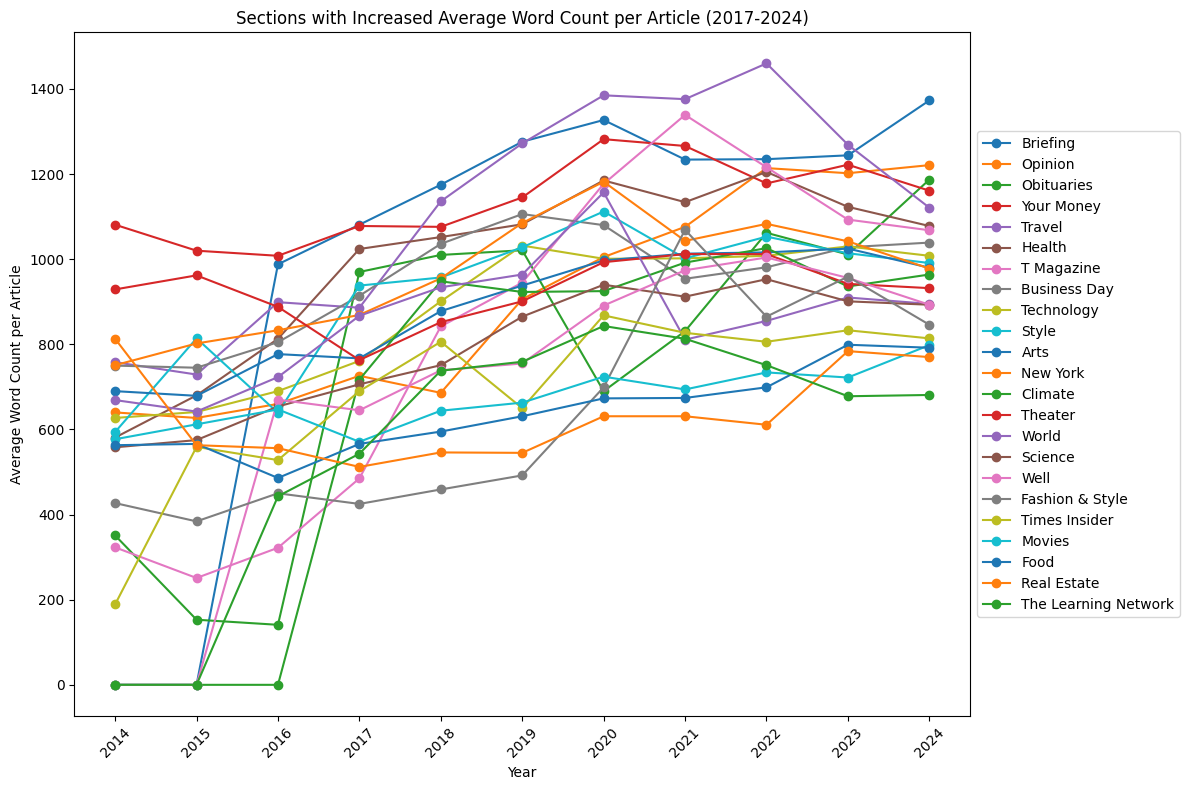

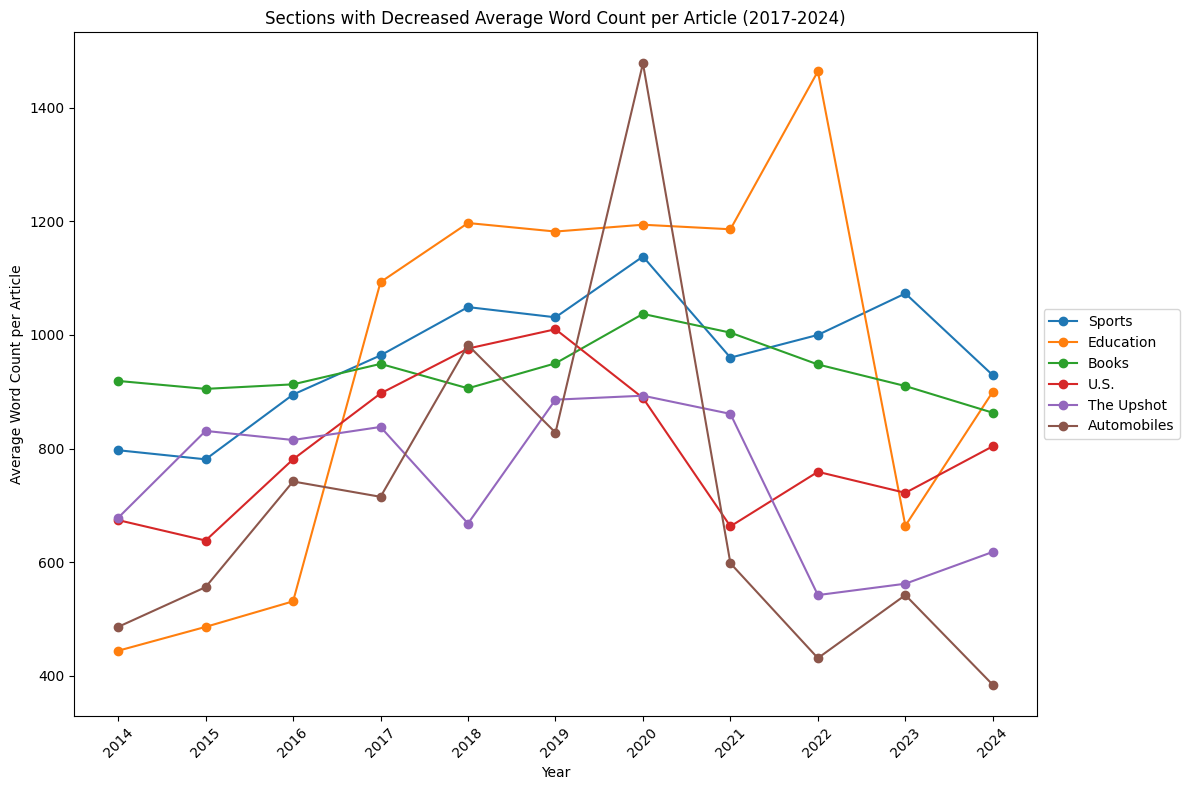

In [42]:
#WORDS PER SECTION

# Ensure 'pub_date' is in datetime format
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'])

# Extract year from 'pub_date'
df_articles['year'] = df_articles['pub_date'].dt.year


# Calculate total word count and number of articles per section per year
section_year_summary = df_articles.groupby(['section_name', 'year']).agg(
    total_word_count=('word_count', 'sum'),
    num_articles=('word_count', 'size')
).reset_index()

# Calculate average word count per article for each section per year and round to integers
section_year_summary['average_word_count_per_article'] = (
    (section_year_summary['total_word_count'] / section_year_summary['num_articles']).round().astype(int)
)


# Pivot the data to get years as columns for each section
section_summary_pivot = section_year_summary.pivot_table(
    index='section_name', 
    columns='year', 
    values='average_word_count_per_article'
).fillna(0)

# Rename columns to just the years (remove 'avg_word_count_' prefix)
section_summary_pivot.columns = [str(col) for col in section_summary_pivot.columns]

# Calculate 2017_24_wc_delta
section_summary_pivot['2017_24_wc_delta'] = (
    section_summary_pivot['2024'] - section_summary_pivot['2017']
)

# Filter sections with 800 or more articles
section_article_counts = df_articles.groupby('section_name').size().reset_index(name='num_articles')
valid_sections = section_article_counts[section_article_counts['num_articles'] >= 800]['section_name']

# Filter section_summary_pivot to include only these sections
filtered_sections = section_summary_pivot[
    section_summary_pivot.index.isin(valid_sections)
]

# Apply exclusion list
excluded_sections = [
    'Crosswords & Games', 
    'Corrections', 
    '', 
    'Today’s Paper', 
    'At Home', 
    'Parenting',
    'Podcasts',
    'Magazine',
    'Reader Center',
    'Multimedia/Photos',
    'Smarter Living',
    'Watching',
    'Blogs',
    'NYT Now'
]
filtered_sections = filtered_sections[~filtered_sections.index.isin(excluded_sections)]

# Sort the table by average word count per article in 2024
section_summary_pivot_sorted = filtered_sections.sort_values(by='2024', ascending=False)

# Display the DataFrame with integer values
print(section_summary_pivot_sorted.astype(int))


# Plot sections with positive 2017_24_wc_delta
positive_delta = section_summary_pivot_sorted[section_summary_pivot_sorted['2017_24_wc_delta'] > 0]
fig, ax = plt.subplots(figsize=(12, 8))
for section in positive_delta.index:
    ax.plot(
        positive_delta.columns.difference(['2017_24_wc_delta']), 
        positive_delta.loc[section, positive_delta.columns.difference(['2017_24_wc_delta'])],
        marker='o', label=section
    )

ax.set_title('Sections with Increased Average Word Count per Article (2017-2024)')
ax.set_xlabel('Year')
ax.set_ylabel('Average Word Count per Article')
ax.set_xticks(positive_delta.columns.difference(['2017_24_wc_delta']))
ax.set_xticklabels(positive_delta.columns.difference(['2017_24_wc_delta']), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# Save the plot if needed
plt.savefig('increased_wc_per_article_by_section.png')
plt.show()

# Plot sections with negative 2017_24_wc_delta
negative_delta = section_summary_pivot_sorted[section_summary_pivot_sorted['2017_24_wc_delta'] < 0]
fig, ax = plt.subplots(figsize=(12, 8))
for section in negative_delta.index:
    ax.plot(
        negative_delta.columns.difference(['2017_24_wc_delta']), 
        negative_delta.loc[section, negative_delta.columns.difference(['2017_24_wc_delta'])],
        marker='o', label=section
    )

ax.set_title('Sections with Decreased Average Word Count per Article (2017-2024)')
ax.set_xlabel('Year')
ax.set_ylabel('Average Word Count per Article')
ax.set_xticks(negative_delta.columns.difference(['2017_24_wc_delta']))
ax.set_xticklabels(negative_delta.columns.difference(['2017_24_wc_delta']), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# Save the plot if needed
plt.savefig('decreased_wc_per_article_by_section.png')
plt.show()

/var/folders/16/08fw8cvd0g7495d8392p8vk40000gn/T/ipykernel_12308/4257675162.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  journalist_articles_info['headline'] = journalist_articles_info['headline'].apply(lambda x: x.get('main') if isinstance(x, dict) else x)


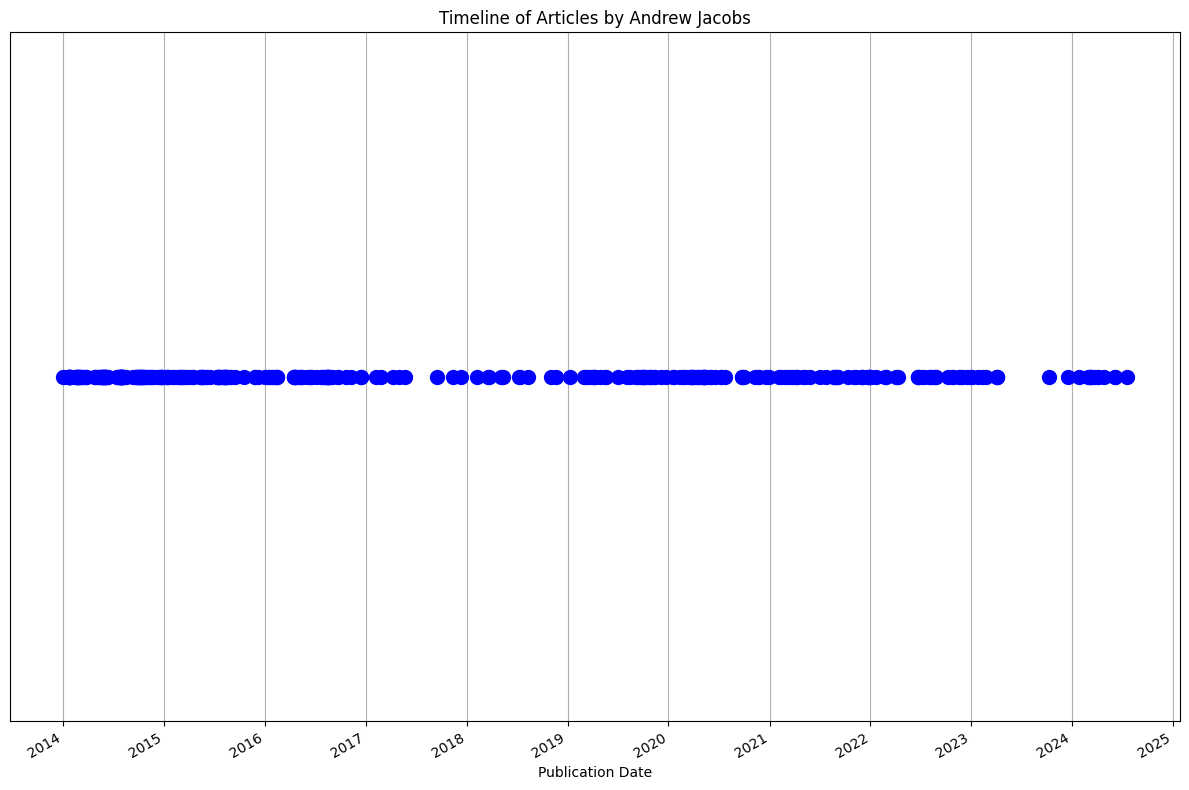

In [92]:
#TIMELINE OF A SPECIFIC AUTHOR

# Define a function to analyze articles by a given journalist's full name
def analyze_journalist(fullname):
    # Find the author_id for the given full name
    author_info = df_authors[df_authors['fullname'] == fullname]
    
    if author_info.empty:
        print(f"No author found with the full name: {fullname}")
        return

    author_id = author_info['author_id'].values[0]
    
    # Filter articles by the found author_id
    journalist_articles = df_articles[df_articles['author_id'].apply(lambda ids: author_id in ids if isinstance(ids, list) else False)]
    
    # Select relevant columns
    journalist_articles_info = journalist_articles[['pub_date', 'headline']]
    
    # Extract the 'main' headline from the 'headline' dictionary
    journalist_articles_info['headline'] = journalist_articles_info['headline'].apply(lambda x: x.get('main') if isinstance(x, dict) else x)
    
    # Sort by publication date
    journalist_articles_info = journalist_articles_info.sort_values(by='pub_date')
    
    # Print or display the result
    journalist_articles_info[:10]
    
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.scatter(journalist_articles_info['pub_date'], [1]*len(journalist_articles_info), color='blue', s=100, zorder=5)
    
    # Formatting
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()
    
    plt.yticks([])  # Remove y-axis ticks
    plt.gca().get_yaxis().set_visible(False)  # Hide y-axis
    
    plt.title(f'Timeline of Articles by {fullname}')
    plt.xlabel('Publication Date')
    plt.grid(True)
    plt.tight_layout()

    # Save the plot as an image file
    plt.savefig(f'timeline_of_articles_{fullname.replace(" ", "_")}.png')

    plt.show()

# Example usage
analyze_journalist('Andrew Jacobs')

In [43]:
filtered_authors = df_authors[df_authors['article_count'] >= 25]
len(filtered_authors)

2548

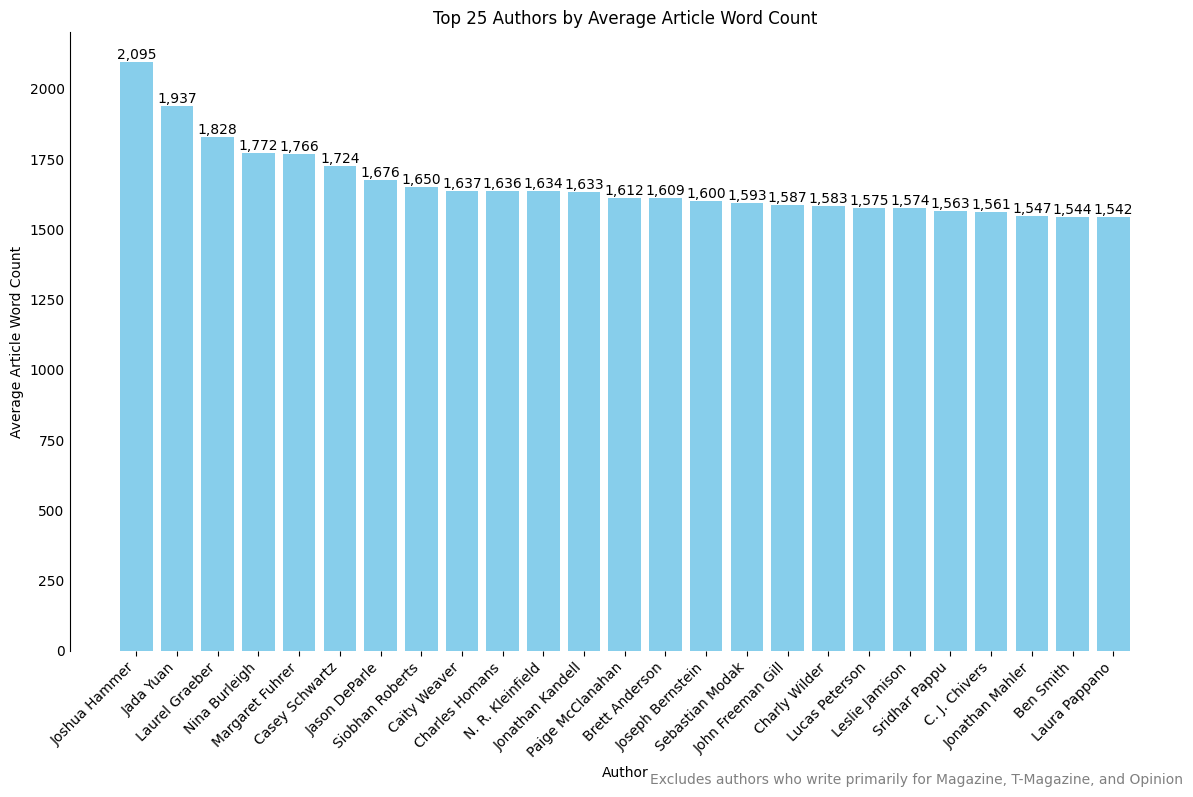

In [45]:
#FINDING THE WORDIEST WRITERS (EXCLUDING WRITERS WHO PRIMARILY WRITE FOR OPINION AND THE MAGAZINES — BUT OTHER AUTHORS STILL HAVE THOSE LONGER PIECES MIXED IN)
# Add the average_word_count column to df_authors
df_authors['average_word_count'] = df_authors['total_authorwords'] / df_authors['article_count']

# Filter authors with over 30 articles
filtered_authors = df_authors[df_authors['article_count'] > 30]

# Exclude authors writing primarily for "Opinion", "Magazine", or "T Magazine"
excluded_sections = ['Opinion', 'Magazine', 'T Magazine']
filtered_authors = filtered_authors[~filtered_authors['most_written_section'].isin(excluded_sections)]

# Select and sort the required columns in descending order of average_word_count
result = filtered_authors[['author_id', 'fullname', 'article_count', 'most_written_section', 'average_word_count']].sort_values(by='average_word_count', ascending=False)

# Display the top 25 authors
top_25 = result.head(25)

# Create the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(top_25['fullname'], top_25['average_word_count'], color='skyblue')

# Add the average word count on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height):,}",  # Display without decimals
        ha="center",
        va="bottom"
    )

# Add title and labels
plt.title('Top 25 Authors by Average Article Word Count')
plt.xlabel('Author')
plt.ylabel('Average Article Word Count')

# Ensure x-axis labels are visible
plt.xticks(rotation=45, ha='right')

# Remove x-axis lines but keep the labels
plt.gca().spines['bottom'].set_visible(False)

# Preserve y-axis label but remove y-axis lines
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(axis='y', which='both', length=0)

# Add a note at the bottom in grey
plt.figtext(
    0.99, 0.01, 
    'Excludes authors who write primarily for Magazine, T-Magazine, and Opinion', 
    horizontalalignment='right', 
    verticalalignment='bottom',
    fontsize=10, 
    color='grey'
)

# Adjust layout to make sure everything fits
plt.tight_layout()

# Save the plot as an image file
plt.savefig('top_25_authors_average_word_count.png')

# Display the plot
plt.show()

Number of articles for author with ID 1478: 38
      author_id  word_count
7187     [1478]        1427
7219     [1478]        3201
22476    [1478]        1232
36026    [1478]        1244
80556    [1478]        1334


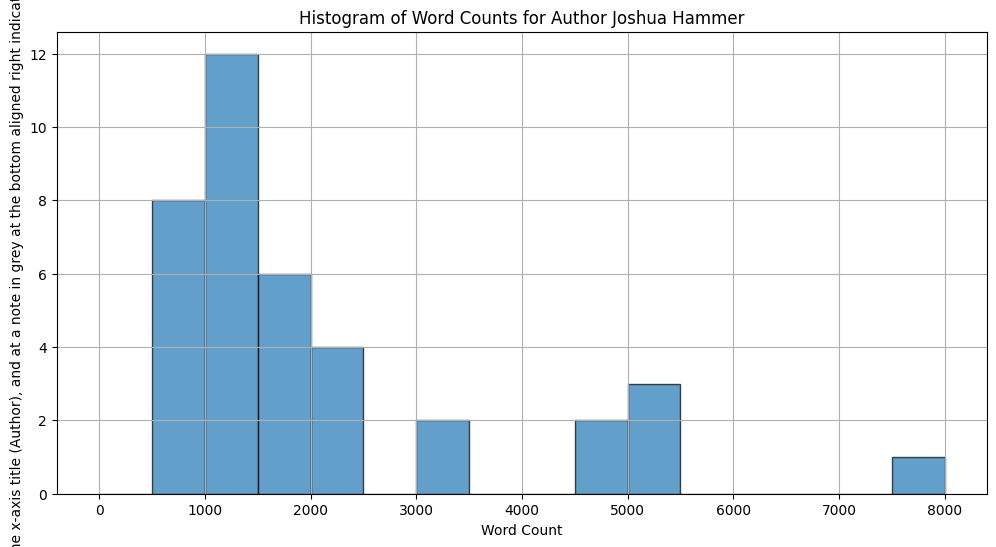

In [46]:
#SEEING THE DISTRIBUTION OF A GIVEN AUTHOR

# Define the author's full name
author_full_name = 'Joshua Hammer'  # Change this to the author's full name you want to analyze

# Look up the author's ID based on their full name
author_info = df_authors[df_authors['fullname'] == author_full_name]
if not author_info.empty:
    author_id = author_info.iloc[0]['author_id']
else:
    raise ValueError(f"No author found with the name {author_full_name}")

# Filter the articles written by the author with the found ID
author_articles = df_articles[df_articles['author_id'].apply(lambda x: author_id in x if isinstance(x, list) else False)]

# Verify the filtering results
print(f"Number of articles for author with ID {author_id}: {len(author_articles)}")
print(author_articles[['author_id', 'word_count']].head())

# Plot histogram of word counts for the selected author
plt.figure(figsize=(12, 6))
plt.hist(author_articles['word_count'], bins=range(0, int(author_articles['word_count'].max()) + 500, 500), edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Number of ArticleThis is fine but lost the y-axis labels and lines, no need for the x-axis title (Author), and at a note in grey at the bottom aligned right indicate: Excludes authors who write primarily for Magazine, T-Magazine, and Opinions')
plt.title(f'Histogram of Word Counts for Author {author_full_name}')
plt.grid(True)

# Save the plot as an image file
plt.savefig(f'{author_full_name}_word_count_histogram.png')

# Display the plot
plt.show()

Number of articles in section 'Books': 20314
    section_name  word_count
85         Books         594
130        Books        1018
204        Books         780
260        Books        1331
276        Books        1189
Number of articles in section 'Movies': 16404
    section_name  word_count
140       Movies        1285
289       Movies           0
300       Movies           0
303       Movies           0
306       Movies           0


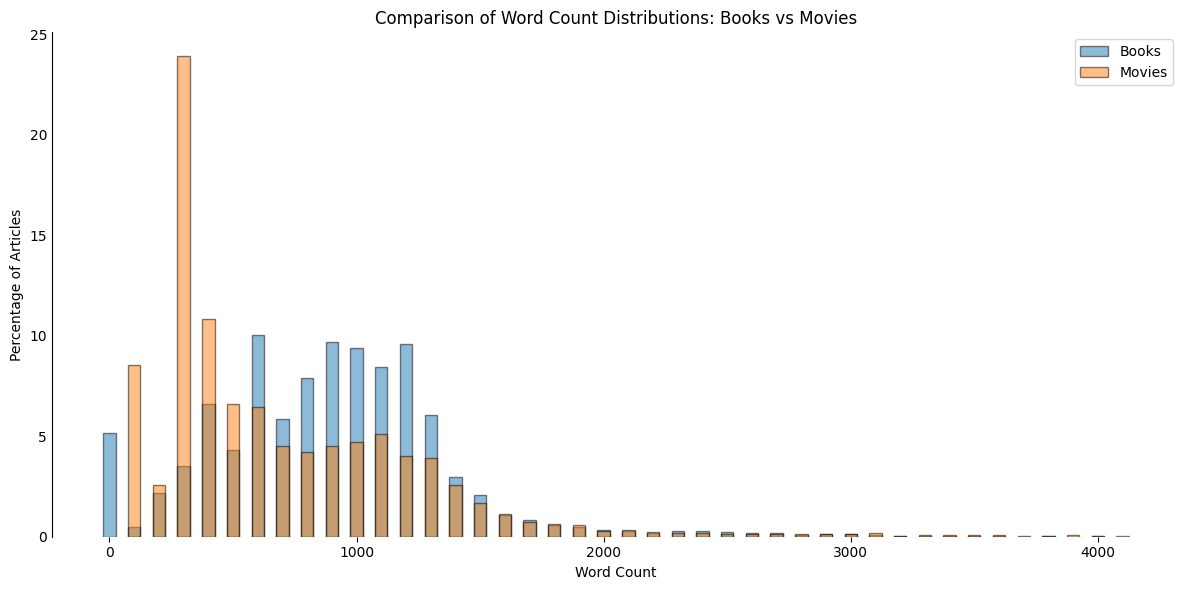

In [64]:
# Define the two sections you want to analyze
section_name1 = 'Books'  # Change this to the first section you want to analyze
section_name2 = 'Movies'   # Change this to the second section you want to analyze

# Filter articles for the given sections
section_articles1 = df_articles[df_articles['section_name'] == section_name1]
section_articles2 = df_articles[df_articles['section_name'] == section_name2]

# Verify the filtering results
print(f"Number of articles in section '{section_name1}': {len(section_articles1)}")
print(section_articles1[['section_name', 'word_count']].head())

print(f"Number of articles in section '{section_name2}': {len(section_articles2)}")
print(section_articles2[['section_name', 'word_count']].head())

# Calculate histogram data for both sections
word_counts1 = section_articles1['word_count']
word_counts2 = section_articles2['word_count']

# Define conservative upper limit based on 99.7th percentile
percentile_997_1 = np.percentile(word_counts1, 99.7)
percentile_997_2 = np.percentile(word_counts2, 99.7)
conservative_limit = max(int(percentile_997_1), int(percentile_997_2))

# Define bins for the histogram
bins = np.arange(0, conservative_limit + 100, 100)

# Calculate histograms
hist1, _ = np.histogram(word_counts1, bins=bins)
hist2, _ = np.histogram(word_counts2, bins=bins)

# Convert counts to percentages
percentages1 = 100 * hist1 / hist1.sum()
percentages2 = 100 * hist2 / hist2.sum()

# Plot the histogram
plt.figure(figsize=(12, 6))
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Make bars slightly more transparent
plt.bar(bin_centers - 50, percentages1, width=50, edgecolor='black', alpha=0.5, label=f'{section_name1}')
plt.bar(bin_centers + 50, percentages2, width=50, edgecolor='black', alpha=0.5, label=f'{section_name2}')

# Set labels and title
plt.xlabel('Word Count')
plt.ylabel('Percentage of Articles')
plt.title(f'Comparison of Word Count Distributions: {section_name1} vs {section_name2}')

# Remove x-axis lines but keep the labels
plt.gca().spines['bottom'].set_visible(False)

# Preserve y-axis label but remove y-axis lines
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(axis='y', which='both', length=0)

# Add a legend
plt.legend()

# Adjust layout to make sure everything fits
plt.tight_layout()

# Save the plot as an image file
plt.savefig(f'{section_name1}_vs_{section_name2}_word_count_comparison.png')

# Display the plot
plt.show()

In [61]:
#DESCRIPTIVE STATS FOR PRESENTATION

# Print the number of unique articles
print("Unique articles:")
print(len(df_articles))

# Print the number of unique authors
print("Unique authors:")
print(len(df_authors))

# Print authors with 25 or more articles
print("Authors with 25+ articles:")
authors_with_25_or_more_articles = df_authors[df_authors['article_count'] >= 25]
print(len(authors_with_25_or_more_articles))

# Print the total number of printed words
print("Total printed words:")
print(df_articles['word_count'].sum())

# Print the number of named sections
print("Number of named sections:")
print(len(df_sections))

Unique articles:
641503
Unique authors:
30238
Authors with 25+ articles:
2548
Total printed words:
524762428
Number of named sections:
76
